In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

## Feature extraction

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

## Reinforcement Learning

### Data Preparation

In [10]:
def train_test_data(ticker, industry_sector, n_tickers, trading_window, min_year=2007, train_max_year=2016):
    
    #Ticker selection
    if ticker is not None:
        tickers = [ticker]
    else:
        #Get list of tickers based on selected industry 
        tickers_lookup = pd.read_csv('tickers_lookup.csv')
        tickers = tickers_lookup[tickers_lookup.INDUSTRY_SECTOR==industry_sector].sort_values('CUR_MKT_CAP',ascending=False)
        tickers = tickers.iloc[:n_tickers]['file_name'] #pick top n tickers by market cap
        tickers = [ticker[:len(ticker)-4] for ticker in tickers] #remove .txt extension
    
    #Empty dataframes to hold full sets of training and test data
    features_train = pd.DataFrame()
    features_test = pd.DataFrame()
    raw_data_train = pd.DataFrame()
    raw_data_test = pd.DataFrame()
    
    for ticker in tickers:
        features_i, raw_data_i = create_features(ticker,trading_window)
        features_i['ticker'] = ticker
        raw_data_i['ticker'] = ticker
        
        #Only keep data after min_year
        features_i['Year'] = pd.to_datetime(features_i.index.values).year
        features_i = features_i.loc[features_i['Year']>min_year]
        raw_data_i = raw_data_i.loc[features_i.index]

        #Split training & testing sets (data points after train_max_year are used for testing)
        features_train_i = features_i.loc[features_i['Year']<train_max_year]
        raw_data_train_i = raw_data_i.loc[features_train_i.index]

        features_test_i = features_i.loc[features_i['Year']>=train_max_year]
        raw_data_test_i = raw_data_i.loc[features_test_i.index]

        #Append to full set of features and raw_data
        features_train = features_train.append(features_train_i)
        raw_data_train = raw_data_train.append(raw_data_train_i)
        features_test = features_test.append(features_test_i)
        raw_data_test = raw_data_test.append(raw_data_test_i)
    
    
    #Remove Year column from features
    features_train = features_train.drop(['Year'], axis = 1)
    features_test = features_test.drop(['Year'], axis = 1)
    
    return features_train, features_test, raw_data_train, raw_data_test

In [11]:
ticker = None
industry_sector = 'Industrial'
n_tickers = 30
trading_window = 21
min_year = 2007
train_max_year = 2016

features_train, features_test, raw_data_train, raw_data_test = train_test_data(ticker,industry_sector,n_tickers,trading_window,min_year,train_max_year)

In [12]:
print('# of total samples: ' + str(features_train.shape[0]+features_test.shape[0]))
print('# of training samples: ' + str(features_train.shape[0]))
print('# of test samples: ' + str(features_test.shape[0]))

# of total samples: 71896
# of training samples: 58025
# of test samples: 13871


### Training

In [16]:
#IPython extension to reload modules, so that kernel does not need to be restarted for every change in the Gym environment
%load_ext autoreload
%autoreload 2

Set up environment for training:

In [22]:
import gym
import gym_market
import numpy as np
import imp

pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_train, 
                  'raw_data':raw_data_train}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Test environment:

In [24]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2]
Rewards: [0.44999999999999996, 0.3799999999999999, -2.62, -3.67, -0.69, 1.32, -0.83, -0.98, 0.27, -0.75, 0.18000000000000005, -2.8, -0.95, 0.15000000000000002, -0.8699999999999999, 0.06000000000000005, -0.98, -2.92, -3.9699999999999998, -4.04, -1.08]
Return: 1.0530790172350255


In [25]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

Neural net architecture:

In [26]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [27]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [28]:
train_episodes = 6000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [29]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [30]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [31]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -32.510000000000005 Training loss: 3.5565 Explore P: 0.9979 Total return: 1.01
Episode: 2 Total reward: -32.37 Training loss: 3.5796 Explore P: 0.9959 Total return: 0.83
Episode: 3 Total reward: -15.079999999999998 Training loss: 3.6253 Explore P: 0.9938 Total return: 1.02
Episode: 4 Total reward: -18.980000000000004 Training loss: 1.6181 Explore P: 0.9917 Total return: 1.09
Episode: 5 Total reward: -23.700000000000003 Training loss: 3.7958 Explore P: 0.9897 Total return: 1.07
Episode: 6 Total reward: -42.04999999999999 Training loss: 3.0216 Explore P: 0.9876 Total return: 0.88
Episode: 7 Total reward: -39.9 Training loss: 4.6098 Explore P: 0.9856 Total return: 1.05
Episode: 8 Total reward: -30.270000000000003 Training loss: 3.9534 Explore P: 0.9835 Total return: 0.94
Episode: 9 Total reward: -31.32 Training loss: 1.1748 Explore P: 0.9815 Total return: 0.88
Episode: 10 Total reward: -34.85 Training loss: 3.3897 Explore P: 0.9794 Total return: 0.88
Episode: 11 T

Episode: 85 Total reward: -27.930000000000007 Training loss: 2.5688 Explore P: 0.8382 Total return: 0.91
Episode: 86 Total reward: -27.380000000000003 Training loss: 4.0088 Explore P: 0.8364 Total return: 0.97
Episode: 87 Total reward: -34.06 Training loss: 3.6375 Explore P: 0.8347 Total return: 0.86
Episode: 88 Total reward: -30.560000000000006 Training loss: 3.1020 Explore P: 0.8330 Total return: 0.90
Episode: 89 Total reward: -21.419999999999998 Training loss: 2.5788 Explore P: 0.8312 Total return: 1.04
Episode: 90 Total reward: -16.239999999999995 Training loss: 1.6302 Explore P: 0.8295 Total return: 1.11
Episode: 91 Total reward: -38.010000000000005 Training loss: 3.1660 Explore P: 0.8278 Total return: 0.92
Episode: 92 Total reward: -27.810000000000002 Training loss: 3.4949 Explore P: 0.8261 Total return: 1.03
Episode: 93 Total reward: -24.609999999999996 Training loss: 3.9177 Explore P: 0.8244 Total return: 1.10
Episode: 94 Total reward: -20.839999999999996 Training loss: 3.5795 

Episode: 167 Total reward: -40.31999999999999 Training loss: 2.9727 Explore P: 0.7072 Total return: 0.64
Episode: 168 Total reward: -22.330000000000005 Training loss: 1.9119 Explore P: 0.7057 Total return: 1.08
Episode: 169 Total reward: -32.74 Training loss: 1.5780 Explore P: 0.7042 Total return: 1.05
Episode: 170 Total reward: -23.299999999999997 Training loss: 2.5578 Explore P: 0.7028 Total return: 1.03
Episode: 171 Total reward: -35.28 Training loss: 3.6164 Explore P: 0.7013 Total return: 0.76
Episode: 172 Total reward: -27.21 Training loss: 4.2863 Explore P: 0.6999 Total return: 0.98
Episode: 173 Total reward: -19.77 Training loss: 3.1475 Explore P: 0.6984 Total return: 1.03
Episode: 174 Total reward: -27.459999999999997 Training loss: 1.7842 Explore P: 0.6970 Total return: 0.97
Episode: 175 Total reward: -28.43 Training loss: 2.5038 Explore P: 0.6955 Total return: 0.97
Episode: 176 Total reward: -28.87 Training loss: 2.0378 Explore P: 0.6941 Total return: 0.99
Episode: 177 Total 

Episode: 252 Total reward: -38.41 Training loss: 2.7423 Explore P: 0.5932 Total return: 0.90
Episode: 253 Total reward: -27.610000000000003 Training loss: 2.4656 Explore P: 0.5920 Total return: 0.93
Episode: 254 Total reward: -39.589999999999996 Training loss: 3.0650 Explore P: 0.5907 Total return: 0.92
Episode: 255 Total reward: -41.16 Training loss: 3.6185 Explore P: 0.5895 Total return: 0.88
Episode: 256 Total reward: -23.53 Training loss: 3.2763 Explore P: 0.5883 Total return: 0.96
Episode: 257 Total reward: -24.13 Training loss: 1.9499 Explore P: 0.5871 Total return: 0.98
Episode: 258 Total reward: -32.480000000000004 Training loss: 2.7050 Explore P: 0.5859 Total return: 0.89
Episode: 259 Total reward: -24.54 Training loss: 2.9445 Explore P: 0.5847 Total return: 1.03
Episode: 260 Total reward: -24.21 Training loss: 3.4425 Explore P: 0.5835 Total return: 1.04
Episode: 261 Total reward: -26.520000000000003 Training loss: 3.2212 Explore P: 0.5823 Total return: 0.98
Episode: 262 Total

Episode: 336 Total reward: -10.999999999999998 Training loss: 2.2884 Explore P: 0.4989 Total return: 1.08
Episode: 337 Total reward: -22.58 Training loss: 2.1923 Explore P: 0.4978 Total return: 1.02
Episode: 338 Total reward: -9.2 Training loss: 3.8042 Explore P: 0.4968 Total return: 1.06
Episode: 339 Total reward: -22.360000000000007 Training loss: 2.0306 Explore P: 0.4958 Total return: 1.04
Episode: 340 Total reward: -28.070000000000004 Training loss: 2.0585 Explore P: 0.4948 Total return: 0.95
Episode: 341 Total reward: -28.600000000000005 Training loss: 2.8536 Explore P: 0.4938 Total return: 0.86
Episode: 342 Total reward: -33.75000000000001 Training loss: 1.5196 Explore P: 0.4928 Total return: 0.72
Episode: 343 Total reward: -23.81 Training loss: 2.7766 Explore P: 0.4917 Total return: 0.84
Episode: 344 Total reward: -42.849999999999994 Training loss: 2.7948 Explore P: 0.4907 Total return: 0.40
Episode: 345 Total reward: -32.93 Training loss: 2.2144 Explore P: 0.4897 Total return: 

Episode: 420 Total reward: -31.640000000000004 Training loss: 2.4328 Explore P: 0.4198 Total return: 1.00
Episode: 421 Total reward: -22.619999999999997 Training loss: 1.5562 Explore P: 0.4190 Total return: 1.02
Episode: 422 Total reward: -22.6 Training loss: 1.3278 Explore P: 0.4181 Total return: 1.06
Episode: 423 Total reward: -25.299999999999997 Training loss: 2.3092 Explore P: 0.4172 Total return: 1.03
Episode: 424 Total reward: -31.37 Training loss: 1.1004 Explore P: 0.4164 Total return: 0.91
Episode: 425 Total reward: -26.97 Training loss: 2.9968 Explore P: 0.4155 Total return: 0.92
Episode: 426 Total reward: -21.880000000000003 Training loss: 3.5129 Explore P: 0.4147 Total return: 0.99
Episode: 427 Total reward: -22.779999999999998 Training loss: 1.8683 Explore P: 0.4138 Total return: 0.90
Episode: 428 Total reward: -20.75 Training loss: 1.8621 Explore P: 0.4130 Total return: 1.00
Episode: 429 Total reward: -17.870000000000005 Training loss: 1.6605 Explore P: 0.4121 Total return

Episode: 504 Total reward: -21.590000000000003 Training loss: 3.3368 Explore P: 0.3535 Total return: 1.00
Episode: 505 Total reward: -24.75 Training loss: 2.2569 Explore P: 0.3528 Total return: 0.94
Episode: 506 Total reward: -26.03 Training loss: 2.1063 Explore P: 0.3521 Total return: 0.97
Episode: 507 Total reward: -27.959999999999997 Training loss: 1.2888 Explore P: 0.3514 Total return: 0.91
Episode: 508 Total reward: -20.100000000000005 Training loss: 2.3439 Explore P: 0.3507 Total return: 1.01
Episode: 509 Total reward: -24.53 Training loss: 2.9692 Explore P: 0.3500 Total return: 0.95
Episode: 510 Total reward: -32.38 Training loss: 1.8745 Explore P: 0.3492 Total return: 0.92
Episode: 511 Total reward: -29.859999999999996 Training loss: 3.5227 Explore P: 0.3485 Total return: 0.93
Episode: 512 Total reward: -23.1 Training loss: 2.7572 Explore P: 0.3478 Total return: 0.97
Episode: 513 Total reward: -20.940000000000005 Training loss: 1.1010 Explore P: 0.3471 Total return: 1.10
Episod

Episode: 588 Total reward: -18.790000000000003 Training loss: 1.2179 Explore P: 0.2980 Total return: 0.93
Episode: 589 Total reward: -27.14 Training loss: 2.5049 Explore P: 0.2974 Total return: 0.96
Episode: 590 Total reward: -30.189999999999998 Training loss: 2.7704 Explore P: 0.2968 Total return: 0.99
Episode: 591 Total reward: -27.939999999999998 Training loss: 3.3922 Explore P: 0.2962 Total return: 0.80
Episode: 592 Total reward: -23.430000000000003 Training loss: 2.8005 Explore P: 0.2956 Total return: 0.98
Episode: 593 Total reward: -13.15 Training loss: 1.6654 Explore P: 0.2950 Total return: 1.06
Episode: 594 Total reward: -26.150000000000006 Training loss: 2.0450 Explore P: 0.2944 Total return: 0.96
Episode: 595 Total reward: -27.95 Training loss: 2.2079 Explore P: 0.2938 Total return: 1.10
Episode: 596 Total reward: -27.640000000000004 Training loss: 2.0569 Explore P: 0.2932 Total return: 1.04
Episode: 597 Total reward: -28.080000000000002 Training loss: 2.6754 Explore P: 0.292

Episode: 671 Total reward: -16.34 Training loss: 1.6643 Explore P: 0.2519 Total return: 1.11
Episode: 672 Total reward: -28.28 Training loss: 1.7115 Explore P: 0.2514 Total return: 1.02
Episode: 673 Total reward: -20.46 Training loss: 1.3045 Explore P: 0.2509 Total return: 1.05
Episode: 674 Total reward: -24.54 Training loss: 1.6196 Explore P: 0.2504 Total return: 0.94
Episode: 675 Total reward: -30.360000000000003 Training loss: 1.6282 Explore P: 0.2499 Total return: 0.92
Episode: 676 Total reward: -35.01 Training loss: 2.3045 Explore P: 0.2494 Total return: 0.94
Episode: 677 Total reward: -31.020000000000003 Training loss: 1.5626 Explore P: 0.2489 Total return: 0.85
Episode: 678 Total reward: -22.719999999999995 Training loss: 2.3458 Explore P: 0.2484 Total return: 0.98
Episode: 679 Total reward: -15.179999999999998 Training loss: 2.9984 Explore P: 0.2479 Total return: 1.02
Episode: 680 Total reward: -24.009999999999998 Training loss: 2.3009 Explore P: 0.2474 Total return: 0.92
Episo

Episode: 755 Total reward: -25.640000000000004 Training loss: 2.5183 Explore P: 0.2128 Total return: 0.99
Episode: 756 Total reward: -21.89 Training loss: 0.9692 Explore P: 0.2124 Total return: 1.08
Episode: 757 Total reward: -36.32 Training loss: 2.1953 Explore P: 0.2119 Total return: 0.98
Episode: 758 Total reward: -32.94 Training loss: 1.9284 Explore P: 0.2115 Total return: 0.83
Episode: 759 Total reward: -31.199999999999992 Training loss: 1.5422 Explore P: 0.2111 Total return: 0.99
Episode: 760 Total reward: -20.400000000000006 Training loss: 1.5895 Explore P: 0.2107 Total return: 0.99
Episode: 761 Total reward: -31.240000000000002 Training loss: 2.4023 Explore P: 0.2103 Total return: 1.00
Episode: 762 Total reward: -30.440000000000005 Training loss: 1.4113 Explore P: 0.2098 Total return: 0.96
Episode: 763 Total reward: -25.85 Training loss: 1.1589 Explore P: 0.2094 Total return: 1.07
Episode: 764 Total reward: -33.37 Training loss: 0.8270 Explore P: 0.2090 Total return: 0.99
Episo

Episode: 838 Total reward: -15.030000000000001 Training loss: 1.2161 Explore P: 0.1804 Total return: 0.99
Episode: 839 Total reward: -29.39 Training loss: 2.5579 Explore P: 0.1800 Total return: 0.93
Episode: 840 Total reward: -23.700000000000003 Training loss: 2.1340 Explore P: 0.1796 Total return: 0.90
Episode: 841 Total reward: -26.48 Training loss: 0.7878 Explore P: 0.1793 Total return: 0.96
Episode: 842 Total reward: -27.07 Training loss: 1.9106 Explore P: 0.1789 Total return: 0.97
Episode: 843 Total reward: -16.81 Training loss: 2.0577 Explore P: 0.1786 Total return: 1.00
Episode: 844 Total reward: -23.67 Training loss: 2.1464 Explore P: 0.1782 Total return: 0.83
Episode: 845 Total reward: -25.230000000000008 Training loss: 0.7246 Explore P: 0.1779 Total return: 0.91
Episode: 846 Total reward: -45.15 Training loss: 2.1415 Explore P: 0.1775 Total return: 1.00
Episode: 847 Total reward: -33.31 Training loss: 1.3683 Explore P: 0.1772 Total return: 0.99
Episode: 848 Total reward: -23.

Episode: 921 Total reward: -21.590000000000003 Training loss: 0.9964 Explore P: 0.1531 Total return: 0.98
Episode: 922 Total reward: -33.33 Training loss: 1.6003 Explore P: 0.1528 Total return: 1.04
Episode: 923 Total reward: -17.23 Training loss: 2.3696 Explore P: 0.1525 Total return: 0.98
Episode: 924 Total reward: -31.5 Training loss: 1.0829 Explore P: 0.1522 Total return: 1.04
Episode: 925 Total reward: -34.48 Training loss: 1.8599 Explore P: 0.1519 Total return: 0.90
Episode: 926 Total reward: -22.490000000000006 Training loss: 3.1244 Explore P: 0.1516 Total return: 0.98
Episode: 927 Total reward: -24.529999999999998 Training loss: 2.6102 Explore P: 0.1513 Total return: 0.95
Episode: 928 Total reward: -17.49 Training loss: 1.8480 Explore P: 0.1510 Total return: 1.00
Episode: 929 Total reward: -15.180000000000003 Training loss: 1.4583 Explore P: 0.1507 Total return: 1.01
Episode: 930 Total reward: -27.6 Training loss: 2.8880 Explore P: 0.1504 Total return: 0.85
Episode: 931 Total r

Episode: 1004 Total reward: -13.85 Training loss: 0.9346 Explore P: 0.1302 Total return: 1.09
Episode: 1005 Total reward: -19.81 Training loss: 2.2249 Explore P: 0.1300 Total return: 1.09
Episode: 1006 Total reward: -25.23 Training loss: 1.7411 Explore P: 0.1297 Total return: 0.97
Episode: 1007 Total reward: -17.42 Training loss: 1.0746 Explore P: 0.1295 Total return: 1.05
Episode: 1008 Total reward: -27.840000000000003 Training loss: 2.6547 Explore P: 0.1292 Total return: 0.93
Episode: 1009 Total reward: -15.5 Training loss: 2.1058 Explore P: 0.1290 Total return: 1.07
Episode: 1010 Total reward: -30.43 Training loss: 0.6622 Explore P: 0.1287 Total return: 0.98
Episode: 1011 Total reward: -16.020000000000003 Training loss: 1.7677 Explore P: 0.1285 Total return: 1.00
Episode: 1012 Total reward: -23.940000000000005 Training loss: 2.3041 Explore P: 0.1282 Total return: 1.10
Episode: 1013 Total reward: -23.78 Training loss: 1.2963 Explore P: 0.1280 Total return: 0.98
Episode: 1014 Total re

Episode: 1087 Total reward: -24.4 Training loss: 1.2306 Explore P: 0.1110 Total return: 0.93
Episode: 1088 Total reward: -16.09 Training loss: 1.8750 Explore P: 0.1108 Total return: 1.02
Episode: 1089 Total reward: -25.950000000000003 Training loss: 0.8826 Explore P: 0.1106 Total return: 0.93
Episode: 1090 Total reward: -47.96 Training loss: 2.3708 Explore P: 0.1104 Total return: 0.92
Episode: 1091 Total reward: -16.94 Training loss: 0.7789 Explore P: 0.1101 Total return: 0.96
Episode: 1092 Total reward: -22.259999999999998 Training loss: 1.3103 Explore P: 0.1099 Total return: 0.96
Episode: 1093 Total reward: -21.77 Training loss: 1.8340 Explore P: 0.1097 Total return: 0.97
Episode: 1094 Total reward: -20.029999999999998 Training loss: 2.6733 Explore P: 0.1095 Total return: 1.00
Episode: 1095 Total reward: -15.63 Training loss: 1.9649 Explore P: 0.1093 Total return: 1.05
Episode: 1096 Total reward: -33.50000000000001 Training loss: 1.1354 Explore P: 0.1091 Total return: 0.94
Episode: 1

Episode: 1171 Total reward: -21.880000000000003 Training loss: 2.3407 Explore P: 0.0947 Total return: 0.95
Episode: 1172 Total reward: -12.27 Training loss: 1.1232 Explore P: 0.0945 Total return: 1.05
Episode: 1173 Total reward: -16.38 Training loss: 1.6752 Explore P: 0.0943 Total return: 1.01
Episode: 1174 Total reward: -15.09 Training loss: 0.8100 Explore P: 0.0941 Total return: 1.01
Episode: 1175 Total reward: -16.13 Training loss: 2.3422 Explore P: 0.0939 Total return: 1.08
Episode: 1176 Total reward: -27.889999999999997 Training loss: 3.0678 Explore P: 0.0938 Total return: 0.94
Episode: 1177 Total reward: -14.100000000000001 Training loss: 1.2858 Explore P: 0.0936 Total return: 1.08
Episode: 1178 Total reward: -17.5 Training loss: 2.2511 Explore P: 0.0934 Total return: 1.07
Episode: 1179 Total reward: -31.509999999999998 Training loss: 3.1487 Explore P: 0.0932 Total return: 0.89
Episode: 1180 Total reward: -24.229999999999997 Training loss: 0.6572 Explore P: 0.0931 Total return: 0

Episode: 1253 Total reward: -28.430000000000003 Training loss: 0.9471 Explore P: 0.0813 Total return: 0.71
Episode: 1254 Total reward: -26.309999999999995 Training loss: 2.9290 Explore P: 0.0811 Total return: 0.97
Episode: 1255 Total reward: -10.689999999999998 Training loss: 0.9906 Explore P: 0.0810 Total return: 1.08
Episode: 1256 Total reward: -9.760000000000002 Training loss: 0.4236 Explore P: 0.0808 Total return: 1.12
Episode: 1257 Total reward: -13.47 Training loss: 1.8253 Explore P: 0.0807 Total return: 0.99
Episode: 1258 Total reward: -17.669999999999998 Training loss: 1.3835 Explore P: 0.0805 Total return: 1.01
Episode: 1259 Total reward: -25.979999999999997 Training loss: 1.8749 Explore P: 0.0804 Total return: 0.93
Episode: 1260 Total reward: -17.93 Training loss: 1.9520 Explore P: 0.0802 Total return: 1.12
Episode: 1261 Total reward: -26.02 Training loss: 1.4182 Explore P: 0.0801 Total return: 1.04
Episode: 1262 Total reward: -23.35 Training loss: 2.0246 Explore P: 0.0799 To

Episode: 1336 Total reward: -18.709999999999997 Training loss: 1.9602 Explore P: 0.0699 Total return: 1.01
Episode: 1337 Total reward: -32.1 Training loss: 1.5349 Explore P: 0.0697 Total return: 0.99
Episode: 1338 Total reward: -16.87 Training loss: 2.2271 Explore P: 0.0696 Total return: 1.02
Episode: 1339 Total reward: -19.89 Training loss: 1.0961 Explore P: 0.0695 Total return: 1.01
Episode: 1340 Total reward: -20.599999999999998 Training loss: 0.8982 Explore P: 0.0694 Total return: 0.95
Episode: 1341 Total reward: -23.169999999999998 Training loss: 2.4790 Explore P: 0.0692 Total return: 0.93
Episode: 1342 Total reward: -21.410000000000004 Training loss: 2.5737 Explore P: 0.0691 Total return: 1.22
Episode: 1343 Total reward: -18.75 Training loss: 1.1781 Explore P: 0.0690 Total return: 0.97
Episode: 1344 Total reward: -17.479999999999997 Training loss: 1.2610 Explore P: 0.0689 Total return: 1.09
Episode: 1345 Total reward: -21.53 Training loss: 1.9129 Explore P: 0.0687 Total return: 1

Episode: 1419 Total reward: -16.959999999999994 Training loss: 3.4534 Explore P: 0.0603 Total return: 1.03
Episode: 1420 Total reward: -30.18 Training loss: 1.8929 Explore P: 0.0602 Total return: 1.03
Episode: 1421 Total reward: -16.62 Training loss: 2.7742 Explore P: 0.0601 Total return: 1.12
Episode: 1422 Total reward: -24.98 Training loss: 1.4203 Explore P: 0.0600 Total return: 1.04
Episode: 1423 Total reward: -19.5 Training loss: 1.6077 Explore P: 0.0599 Total return: 0.94
Episode: 1424 Total reward: -19.669999999999998 Training loss: 3.2028 Explore P: 0.0598 Total return: 1.03
Episode: 1425 Total reward: -23.439999999999998 Training loss: 1.2557 Explore P: 0.0597 Total return: 0.96
Episode: 1426 Total reward: -28.540000000000006 Training loss: 1.5015 Explore P: 0.0596 Total return: 0.90
Episode: 1427 Total reward: -14.63 Training loss: 2.0190 Explore P: 0.0595 Total return: 1.08
Episode: 1428 Total reward: -29.109999999999996 Training loss: 0.4933 Explore P: 0.0593 Total return: 0

Episode: 1503 Total reward: -16.91 Training loss: 1.1871 Explore P: 0.0522 Total return: 0.99
Episode: 1504 Total reward: -25.28000000000001 Training loss: 1.9443 Explore P: 0.0521 Total return: 0.86
Episode: 1505 Total reward: -30.86 Training loss: 0.5930 Explore P: 0.0520 Total return: 0.57
Episode: 1506 Total reward: -24.91 Training loss: 1.1793 Explore P: 0.0519 Total return: 1.01
Episode: 1507 Total reward: -33.96 Training loss: 2.0678 Explore P: 0.0518 Total return: 1.04
Episode: 1508 Total reward: -21.43 Training loss: 3.2488 Explore P: 0.0517 Total return: 0.93
Episode: 1509 Total reward: -18.58 Training loss: 1.7648 Explore P: 0.0516 Total return: 0.99
Episode: 1510 Total reward: -19.630000000000003 Training loss: 1.5069 Explore P: 0.0515 Total return: 0.97
Episode: 1511 Total reward: -24.670000000000005 Training loss: 2.0202 Explore P: 0.0515 Total return: 0.93
Episode: 1512 Total reward: -20.94 Training loss: 2.4784 Explore P: 0.0514 Total return: 0.98
Episode: 1513 Total re

Episode: 1587 Total reward: -19.299999999999997 Training loss: 2.0331 Explore P: 0.0453 Total return: 0.98
Episode: 1588 Total reward: -17.37 Training loss: 1.6583 Explore P: 0.0453 Total return: 0.97
Episode: 1589 Total reward: -20.95 Training loss: 1.4264 Explore P: 0.0452 Total return: 0.98
Episode: 1590 Total reward: -13.969999999999999 Training loss: 1.6010 Explore P: 0.0451 Total return: 1.04
Episode: 1591 Total reward: -22.180000000000003 Training loss: 1.6491 Explore P: 0.0450 Total return: 0.96
Episode: 1592 Total reward: -18.21 Training loss: 1.2262 Explore P: 0.0450 Total return: 0.98
Episode: 1593 Total reward: -24.79 Training loss: 1.6748 Explore P: 0.0449 Total return: 0.99
Episode: 1594 Total reward: -17.31 Training loss: 0.5539 Explore P: 0.0448 Total return: 1.01
Episode: 1595 Total reward: -27.03 Training loss: 1.8169 Explore P: 0.0448 Total return: 1.04
Episode: 1596 Total reward: -29.160000000000004 Training loss: 0.6578 Explore P: 0.0447 Total return: 0.90
Episode:

Episode: 1670 Total reward: -13.049999999999999 Training loss: 1.2350 Explore P: 0.0397 Total return: 1.03
Episode: 1671 Total reward: -16.69 Training loss: 0.8860 Explore P: 0.0396 Total return: 1.10
Episode: 1672 Total reward: -19.52 Training loss: 1.3369 Explore P: 0.0396 Total return: 1.05
Episode: 1673 Total reward: -18.869999999999997 Training loss: 0.7349 Explore P: 0.0395 Total return: 1.10
Episode: 1674 Total reward: -50.510000000000005 Training loss: 1.2209 Explore P: 0.0394 Total return: 0.85
Episode: 1675 Total reward: -19.070000000000004 Training loss: 1.5879 Explore P: 0.0394 Total return: 1.03
Episode: 1676 Total reward: -14.270000000000001 Training loss: 1.8551 Explore P: 0.0393 Total return: 1.02
Episode: 1677 Total reward: -21.780000000000005 Training loss: 2.0833 Explore P: 0.0393 Total return: 0.91
Episode: 1678 Total reward: -18.73 Training loss: 2.9666 Explore P: 0.0392 Total return: 0.99
Episode: 1679 Total reward: -25.050000000000004 Training loss: 2.2549 Explor

Episode: 1752 Total reward: -14.070000000000002 Training loss: 0.7968 Explore P: 0.0350 Total return: 1.08
Episode: 1753 Total reward: -24.75 Training loss: 1.5376 Explore P: 0.0349 Total return: 0.83
Episode: 1754 Total reward: -14.11 Training loss: 1.3444 Explore P: 0.0349 Total return: 1.06
Episode: 1755 Total reward: -24.999999999999996 Training loss: 0.9687 Explore P: 0.0348 Total return: 0.93
Episode: 1756 Total reward: -25.390000000000004 Training loss: 0.6012 Explore P: 0.0348 Total return: 0.95
Episode: 1757 Total reward: -23.619999999999997 Training loss: 1.2553 Explore P: 0.0347 Total return: 0.99
Episode: 1758 Total reward: -25.85 Training loss: 1.1585 Explore P: 0.0347 Total return: 0.93
Episode: 1759 Total reward: -16.19 Training loss: 1.7568 Explore P: 0.0346 Total return: 1.01
Episode: 1760 Total reward: -21.359999999999996 Training loss: 0.9777 Explore P: 0.0346 Total return: 1.11
Episode: 1761 Total reward: -25.920000000000005 Training loss: 0.4955 Explore P: 0.0345 T

Episode: 1833 Total reward: -17.58 Training loss: 1.1731 Explore P: 0.0311 Total return: 1.04
Episode: 1834 Total reward: -10.129999999999999 Training loss: 1.2689 Explore P: 0.0310 Total return: 1.05
Episode: 1835 Total reward: -17.45 Training loss: 1.4420 Explore P: 0.0310 Total return: 1.05
Episode: 1836 Total reward: -16.31 Training loss: 1.0502 Explore P: 0.0309 Total return: 1.02
Episode: 1837 Total reward: -14.45 Training loss: 1.5127 Explore P: 0.0309 Total return: 1.02
Episode: 1838 Total reward: -24.709999999999997 Training loss: 1.3453 Explore P: 0.0309 Total return: 0.94
Episode: 1839 Total reward: -15.669999999999998 Training loss: 0.7684 Explore P: 0.0308 Total return: 1.00
Episode: 1840 Total reward: -20.810000000000002 Training loss: 0.5557 Explore P: 0.0308 Total return: 1.04
Episode: 1841 Total reward: -35.46000000000001 Training loss: 2.5130 Explore P: 0.0307 Total return: 0.92
Episode: 1842 Total reward: -19.78 Training loss: 1.1178 Explore P: 0.0307 Total return: 0

Episode: 1916 Total reward: -15.55 Training loss: 1.5476 Explore P: 0.0277 Total return: 0.96
Episode: 1917 Total reward: -26.639999999999997 Training loss: 0.4926 Explore P: 0.0277 Total return: 0.86
Episode: 1918 Total reward: -20.080000000000002 Training loss: 2.2632 Explore P: 0.0276 Total return: 0.96
Episode: 1919 Total reward: -28.61 Training loss: 1.5591 Explore P: 0.0276 Total return: 0.89
Episode: 1920 Total reward: -26.33 Training loss: 1.1676 Explore P: 0.0276 Total return: 0.50
Episode: 1921 Total reward: -25.049999999999997 Training loss: 1.2671 Explore P: 0.0275 Total return: 0.97
Episode: 1922 Total reward: -18.45 Training loss: 2.1014 Explore P: 0.0275 Total return: 0.99
Episode: 1923 Total reward: -13.969999999999999 Training loss: 2.3395 Explore P: 0.0275 Total return: 1.03
Episode: 1924 Total reward: -25.17 Training loss: 1.5060 Explore P: 0.0274 Total return: 0.96
Episode: 1925 Total reward: -26.779999999999998 Training loss: 0.2757 Explore P: 0.0274 Total return: 

Episode: 1997 Total reward: -18.29 Training loss: 2.9403 Explore P: 0.0249 Total return: 1.00
Episode: 1998 Total reward: -14.91 Training loss: 2.4970 Explore P: 0.0249 Total return: 1.04
Episode: 1999 Total reward: -20.860000000000007 Training loss: 2.1962 Explore P: 0.0249 Total return: 1.01
Episode: 2000 Total reward: -19.45 Training loss: 0.5128 Explore P: 0.0248 Total return: 0.97
Episode: 2001 Total reward: -10.049999999999997 Training loss: 1.5360 Explore P: 0.0248 Total return: 1.10
Episode: 2002 Total reward: -35.26 Training loss: 1.0881 Explore P: 0.0248 Total return: 0.86
Episode: 2003 Total reward: -15.069999999999999 Training loss: 0.3936 Explore P: 0.0248 Total return: 1.09
Episode: 2004 Total reward: -18.349999999999998 Training loss: 1.6121 Explore P: 0.0247 Total return: 1.01
Episode: 2005 Total reward: -18.59 Training loss: 1.5008 Explore P: 0.0247 Total return: 1.06
Episode: 2006 Total reward: -30.669999999999998 Training loss: 2.3278 Explore P: 0.0247 Total return: 

Episode: 2082 Total reward: -14.309999999999999 Training loss: 1.5081 Explore P: 0.0225 Total return: 1.01
Episode: 2083 Total reward: -26.33 Training loss: 1.2837 Explore P: 0.0225 Total return: 0.97
Episode: 2084 Total reward: -30.96 Training loss: 1.4402 Explore P: 0.0224 Total return: 0.95
Episode: 2085 Total reward: -29.529999999999994 Training loss: 1.2370 Explore P: 0.0224 Total return: 0.95
Episode: 2086 Total reward: -18.950000000000003 Training loss: 1.4692 Explore P: 0.0224 Total return: 0.98
Episode: 2087 Total reward: -16.51 Training loss: 1.2329 Explore P: 0.0224 Total return: 1.01
Episode: 2088 Total reward: -14.669999999999998 Training loss: 2.2923 Explore P: 0.0223 Total return: 1.02
Episode: 2089 Total reward: -21.560000000000006 Training loss: 0.9410 Explore P: 0.0223 Total return: 1.08
Episode: 2090 Total reward: -15.84 Training loss: 1.3083 Explore P: 0.0223 Total return: 1.04
Episode: 2091 Total reward: -25.34 Training loss: 1.4970 Explore P: 0.0223 Total return: 

Episode: 2165 Total reward: -14.969999999999999 Training loss: 2.1149 Explore P: 0.0205 Total return: 1.00
Episode: 2166 Total reward: -18.71 Training loss: 1.0693 Explore P: 0.0205 Total return: 1.07
Episode: 2167 Total reward: -14.309999999999999 Training loss: 0.7537 Explore P: 0.0205 Total return: 1.06
Episode: 2168 Total reward: -23.9 Training loss: 0.7399 Explore P: 0.0204 Total return: 0.98
Episode: 2169 Total reward: -26.01000000000001 Training loss: 0.7159 Explore P: 0.0204 Total return: 0.98
Episode: 2170 Total reward: -15.009999999999998 Training loss: 1.5759 Explore P: 0.0204 Total return: 1.04
Episode: 2171 Total reward: -30.14 Training loss: 1.4064 Explore P: 0.0204 Total return: 0.92
Episode: 2172 Total reward: -19.39 Training loss: 0.8763 Explore P: 0.0203 Total return: 1.01
Episode: 2173 Total reward: -14.749999999999998 Training loss: 1.8119 Explore P: 0.0203 Total return: 1.02
Episode: 2174 Total reward: -15.98 Training loss: 0.6261 Explore P: 0.0203 Total return: 1.

Episode: 2247 Total reward: -17.660000000000004 Training loss: 1.4304 Explore P: 0.0188 Total return: 1.00
Episode: 2248 Total reward: -31.939999999999998 Training loss: 1.7154 Explore P: 0.0188 Total return: 0.94
Episode: 2249 Total reward: -26.109999999999996 Training loss: 1.4488 Explore P: 0.0188 Total return: 0.92
Episode: 2250 Total reward: -19.31 Training loss: 2.1936 Explore P: 0.0188 Total return: 1.06
Episode: 2251 Total reward: -16.240000000000002 Training loss: 1.2895 Explore P: 0.0188 Total return: 1.04
Episode: 2252 Total reward: -18.569999999999997 Training loss: 1.8009 Explore P: 0.0187 Total return: 0.99
Episode: 2253 Total reward: -12.23 Training loss: 1.6237 Explore P: 0.0187 Total return: 1.05
Episode: 2254 Total reward: -23.249999999999996 Training loss: 1.4584 Explore P: 0.0187 Total return: 0.97
Episode: 2255 Total reward: -18.75 Training loss: 2.2176 Explore P: 0.0187 Total return: 0.98
Episode: 2256 Total reward: -25.88 Training loss: 1.7263 Explore P: 0.0187 T

Episode: 2329 Total reward: -22.259999999999998 Training loss: 2.1290 Explore P: 0.0174 Total return: 0.94
Episode: 2330 Total reward: -27.670000000000005 Training loss: 1.6695 Explore P: 0.0174 Total return: 0.98
Episode: 2331 Total reward: -15.450000000000001 Training loss: 1.6780 Explore P: 0.0174 Total return: 1.02
Episode: 2332 Total reward: -19.01 Training loss: 2.6898 Explore P: 0.0174 Total return: 1.00
Episode: 2333 Total reward: -19.03 Training loss: 1.4543 Explore P: 0.0174 Total return: 0.95
Episode: 2334 Total reward: -20.939999999999998 Training loss: 1.2952 Explore P: 0.0174 Total return: 1.01
Episode: 2335 Total reward: -12.17 Training loss: 1.7543 Explore P: 0.0173 Total return: 1.10
Episode: 2336 Total reward: -21.72 Training loss: 1.5439 Explore P: 0.0173 Total return: 0.94
Episode: 2337 Total reward: -27.250000000000004 Training loss: 1.4310 Explore P: 0.0173 Total return: 0.99
Episode: 2338 Total reward: -21.519999999999996 Training loss: 0.8424 Explore P: 0.0173 T

Episode: 2412 Total reward: -16.509999999999998 Training loss: 1.0701 Explore P: 0.0162 Total return: 1.04
Episode: 2413 Total reward: -20.169999999999998 Training loss: 1.8288 Explore P: 0.0162 Total return: 1.01
Episode: 2414 Total reward: -19.340000000000003 Training loss: 1.3961 Explore P: 0.0162 Total return: 1.00
Episode: 2415 Total reward: -21.439999999999998 Training loss: 1.9883 Explore P: 0.0162 Total return: 0.97
Episode: 2416 Total reward: -23.480000000000004 Training loss: 1.6638 Explore P: 0.0162 Total return: 0.99
Episode: 2417 Total reward: -22.27 Training loss: 3.1845 Explore P: 0.0162 Total return: 1.01
Episode: 2418 Total reward: -13.98 Training loss: 1.6391 Explore P: 0.0162 Total return: 1.01
Episode: 2419 Total reward: -18.68 Training loss: 2.4301 Explore P: 0.0162 Total return: 1.18
Episode: 2420 Total reward: -19.910000000000004 Training loss: 1.6194 Explore P: 0.0161 Total return: 1.07
Episode: 2421 Total reward: -25.890000000000004 Training loss: 1.1205 Explor

Episode: 2494 Total reward: -23.48 Training loss: 1.9003 Explore P: 0.0153 Total return: 0.95
Episode: 2495 Total reward: -14.82 Training loss: 1.5877 Explore P: 0.0152 Total return: 0.99
Episode: 2496 Total reward: -20.360000000000003 Training loss: 2.3953 Explore P: 0.0152 Total return: 0.98
Episode: 2497 Total reward: -17.47 Training loss: 1.4326 Explore P: 0.0152 Total return: 0.95
Episode: 2498 Total reward: -15.259999999999998 Training loss: 1.1140 Explore P: 0.0152 Total return: 1.01
Episode: 2499 Total reward: -18.83 Training loss: 2.3321 Explore P: 0.0152 Total return: 1.08
Episode: 2500 Total reward: -24.93 Training loss: 1.8422 Explore P: 0.0152 Total return: 1.02
Episode: 2501 Total reward: -17.62 Training loss: 0.9200 Explore P: 0.0152 Total return: 1.05
Episode: 2502 Total reward: -40.16 Training loss: 0.6155 Explore P: 0.0152 Total return: 0.93
Episode: 2503 Total reward: -32.529999999999994 Training loss: 2.4223 Explore P: 0.0152 Total return: 0.94
Episode: 2504 Total r

Episode: 2576 Total reward: -33.68 Training loss: 1.4319 Explore P: 0.0144 Total return: 0.97
Episode: 2577 Total reward: -15.330000000000002 Training loss: 2.1596 Explore P: 0.0144 Total return: 0.99
Episode: 2578 Total reward: -42.54 Training loss: 2.9091 Explore P: 0.0144 Total return: 0.95
Episode: 2579 Total reward: -23.29 Training loss: 1.4751 Explore P: 0.0144 Total return: 1.00
Episode: 2580 Total reward: -18.81 Training loss: 2.0216 Explore P: 0.0144 Total return: 0.99
Episode: 2581 Total reward: -23.22 Training loss: 0.3088 Explore P: 0.0144 Total return: 0.97
Episode: 2582 Total reward: -22.420000000000005 Training loss: 1.3650 Explore P: 0.0144 Total return: 0.88
Episode: 2583 Total reward: -26.960000000000004 Training loss: 1.6989 Explore P: 0.0144 Total return: 0.97
Episode: 2584 Total reward: -16.349999999999998 Training loss: 1.2904 Explore P: 0.0144 Total return: 1.04
Episode: 2585 Total reward: -17.97 Training loss: 0.8798 Explore P: 0.0143 Total return: 1.02
Episode:

Episode: 2658 Total reward: -13.339999999999998 Training loss: 1.4642 Explore P: 0.0137 Total return: 1.09
Episode: 2659 Total reward: -22.419999999999998 Training loss: 2.9615 Explore P: 0.0137 Total return: 0.95
Episode: 2660 Total reward: -20.48 Training loss: 0.8641 Explore P: 0.0137 Total return: 1.01
Episode: 2661 Total reward: -26.24 Training loss: 0.9442 Explore P: 0.0137 Total return: 1.05
Episode: 2662 Total reward: -14.749999999999998 Training loss: 0.5491 Explore P: 0.0137 Total return: 1.03
Episode: 2663 Total reward: -22.990000000000006 Training loss: 2.4750 Explore P: 0.0137 Total return: 1.00
Episode: 2664 Total reward: -17.810000000000002 Training loss: 2.0146 Explore P: 0.0137 Total return: 1.00
Episode: 2665 Total reward: -20.990000000000002 Training loss: 0.9008 Explore P: 0.0137 Total return: 1.03
Episode: 2666 Total reward: -19.73 Training loss: 2.2310 Explore P: 0.0137 Total return: 0.98
Episode: 2667 Total reward: -25.76 Training loss: 1.2110 Explore P: 0.0137 T

Episode: 2741 Total reward: -27.460000000000004 Training loss: 1.0981 Explore P: 0.0131 Total return: 0.93
Episode: 2742 Total reward: -26.700000000000003 Training loss: 1.4066 Explore P: 0.0131 Total return: 0.75
Episode: 2743 Total reward: -14.67 Training loss: 1.3988 Explore P: 0.0131 Total return: 1.08
Episode: 2744 Total reward: -31.55 Training loss: 2.2707 Explore P: 0.0131 Total return: 0.78
Episode: 2745 Total reward: -14.84 Training loss: 1.6694 Explore P: 0.0131 Total return: 1.05
Episode: 2746 Total reward: -26.819999999999997 Training loss: 1.1561 Explore P: 0.0131 Total return: 0.92
Episode: 2747 Total reward: -19.570000000000007 Training loss: 1.1345 Explore P: 0.0131 Total return: 1.08
Episode: 2748 Total reward: -18.729999999999997 Training loss: 1.2169 Explore P: 0.0131 Total return: 1.01
Episode: 2749 Total reward: -26.11 Training loss: 0.9385 Explore P: 0.0131 Total return: 0.95
Episode: 2750 Total reward: -19.519999999999996 Training loss: 1.6780 Explore P: 0.0131 T

Episode: 2823 Total reward: -14.850000000000001 Training loss: 1.3782 Explore P: 0.0126 Total return: 1.04
Episode: 2824 Total reward: -18.970000000000006 Training loss: 2.0411 Explore P: 0.0126 Total return: 1.00
Episode: 2825 Total reward: -24.059999999999995 Training loss: 1.3256 Explore P: 0.0126 Total return: 0.99
Episode: 2826 Total reward: -14.45 Training loss: 1.4557 Explore P: 0.0126 Total return: 1.01
Episode: 2827 Total reward: -30.200000000000003 Training loss: 1.6701 Explore P: 0.0126 Total return: 0.98
Episode: 2828 Total reward: -19.560000000000002 Training loss: 1.7451 Explore P: 0.0126 Total return: 0.97
Episode: 2829 Total reward: -16.32 Training loss: 0.9243 Explore P: 0.0126 Total return: 1.03
Episode: 2830 Total reward: -17.98 Training loss: 2.5537 Explore P: 0.0126 Total return: 1.13
Episode: 2831 Total reward: -28.750000000000004 Training loss: 0.6593 Explore P: 0.0126 Total return: 0.96
Episode: 2832 Total reward: -23.92 Training loss: 1.4790 Explore P: 0.0126 T

Episode: 2905 Total reward: -20.77 Training loss: 1.1977 Explore P: 0.0122 Total return: 1.15
Episode: 2906 Total reward: -21.960000000000004 Training loss: 1.4175 Explore P: 0.0122 Total return: 0.97
Episode: 2907 Total reward: -16.509999999999998 Training loss: 1.1672 Explore P: 0.0122 Total return: 1.00
Episode: 2908 Total reward: -21.910000000000004 Training loss: 1.8127 Explore P: 0.0122 Total return: 0.91
Episode: 2909 Total reward: -22.620000000000005 Training loss: 2.4354 Explore P: 0.0122 Total return: 0.92
Episode: 2910 Total reward: -25.509999999999998 Training loss: 0.9531 Explore P: 0.0122 Total return: 0.89
Episode: 2911 Total reward: -23.140000000000004 Training loss: 1.0085 Explore P: 0.0122 Total return: 1.11
Episode: 2912 Total reward: -18.32 Training loss: 1.5148 Explore P: 0.0122 Total return: 0.97
Episode: 2913 Total reward: -24.740000000000002 Training loss: 1.7008 Explore P: 0.0122 Total return: 0.95
Episode: 2914 Total reward: -25.600000000000005 Training loss: 

Episode: 2986 Total reward: -11.41 Training loss: 0.8817 Explore P: 0.0119 Total return: 1.08
Episode: 2987 Total reward: -15.820000000000004 Training loss: 1.8007 Explore P: 0.0119 Total return: 1.06
Episode: 2988 Total reward: -16.19 Training loss: 1.2047 Explore P: 0.0119 Total return: 1.04
Episode: 2989 Total reward: -14.480000000000004 Training loss: 1.6211 Explore P: 0.0119 Total return: 1.02
Episode: 2990 Total reward: -16.51 Training loss: 1.0974 Explore P: 0.0119 Total return: 1.03
Episode: 2991 Total reward: -14.11 Training loss: 0.5899 Explore P: 0.0119 Total return: 1.07
Episode: 2992 Total reward: -25.17 Training loss: 1.0873 Explore P: 0.0118 Total return: 0.95
Episode: 2993 Total reward: -45.18000000000001 Training loss: 1.9488 Explore P: 0.0118 Total return: 0.77
Episode: 2994 Total reward: -20.450000000000003 Training loss: 1.0997 Explore P: 0.0118 Total return: 1.01
Episode: 2995 Total reward: -16.549999999999997 Training loss: 1.6628 Explore P: 0.0118 Total return: 1

Episode: 3069 Total reward: -19.790000000000003 Training loss: 1.4294 Explore P: 0.0116 Total return: 0.99
Episode: 3070 Total reward: -20.549999999999997 Training loss: 0.9626 Explore P: 0.0116 Total return: 1.02
Episode: 3071 Total reward: -26.36 Training loss: 0.8194 Explore P: 0.0116 Total return: 0.96
Episode: 3072 Total reward: -14.749999999999998 Training loss: 0.7094 Explore P: 0.0116 Total return: 1.02
Episode: 3073 Total reward: -14.950000000000001 Training loss: 0.6562 Explore P: 0.0116 Total return: 1.03
Episode: 3074 Total reward: -20.569999999999997 Training loss: 1.5975 Explore P: 0.0116 Total return: 1.00
Episode: 3075 Total reward: -18.820000000000007 Training loss: 1.6871 Explore P: 0.0116 Total return: 0.95
Episode: 3076 Total reward: -26.549999999999997 Training loss: 1.0591 Explore P: 0.0115 Total return: 1.02
Episode: 3077 Total reward: -14.27 Training loss: 2.3754 Explore P: 0.0115 Total return: 1.05
Episode: 3078 Total reward: -19.19 Training loss: 3.0120 Explor

Episode: 3152 Total reward: -14.47 Training loss: 1.0580 Explore P: 0.0113 Total return: 1.07
Episode: 3153 Total reward: -23.790000000000003 Training loss: 1.6125 Explore P: 0.0113 Total return: 0.90
Episode: 3154 Total reward: -16.150000000000002 Training loss: 1.6661 Explore P: 0.0113 Total return: 1.01
Episode: 3155 Total reward: -14.669999999999998 Training loss: 1.0093 Explore P: 0.0113 Total return: 1.11
Episode: 3156 Total reward: -22.59 Training loss: 2.0215 Explore P: 0.0113 Total return: 0.92
Episode: 3157 Total reward: -20.96 Training loss: 2.1708 Explore P: 0.0113 Total return: 1.04
Episode: 3158 Total reward: -14.45 Training loss: 1.4761 Explore P: 0.0113 Total return: 1.02
Episode: 3159 Total reward: -20.09 Training loss: 0.8766 Explore P: 0.0113 Total return: 0.98
Episode: 3160 Total reward: -16.33 Training loss: 2.0028 Explore P: 0.0113 Total return: 1.03
Episode: 3161 Total reward: -18.45 Training loss: 1.0556 Explore P: 0.0113 Total return: 0.99
Episode: 3162 Total r

Episode: 3233 Total reward: -14.970000000000002 Training loss: 1.7698 Explore P: 0.0111 Total return: 1.14
Episode: 3234 Total reward: -25.56 Training loss: 1.1929 Explore P: 0.0111 Total return: 1.00
Episode: 3235 Total reward: -17.349999999999998 Training loss: 1.8539 Explore P: 0.0111 Total return: 1.01
Episode: 3236 Total reward: -17.43 Training loss: 1.5008 Explore P: 0.0111 Total return: 1.02
Episode: 3237 Total reward: -23.659999999999997 Training loss: 1.1568 Explore P: 0.0111 Total return: 0.93
Episode: 3238 Total reward: -14.45 Training loss: 1.0532 Explore P: 0.0111 Total return: 1.02
Episode: 3239 Total reward: -11.44 Training loss: 2.3710 Explore P: 0.0111 Total return: 1.06
Episode: 3240 Total reward: -24.99 Training loss: 1.1348 Explore P: 0.0111 Total return: 0.94
Episode: 3241 Total reward: -22.05 Training loss: 0.7586 Explore P: 0.0111 Total return: 0.97
Episode: 3242 Total reward: -14.45 Training loss: 0.3982 Explore P: 0.0111 Total return: 1.01
Episode: 3243 Total r

Episode: 3316 Total reward: -19.290000000000003 Training loss: 1.1125 Explore P: 0.0109 Total return: 0.94
Episode: 3317 Total reward: -20.230000000000004 Training loss: 1.5558 Explore P: 0.0109 Total return: 0.98
Episode: 3318 Total reward: -17.68 Training loss: 0.6389 Explore P: 0.0109 Total return: 1.01
Episode: 3319 Total reward: -27.67 Training loss: 0.7158 Explore P: 0.0109 Total return: 0.86
Episode: 3320 Total reward: -18.75 Training loss: 1.0256 Explore P: 0.0109 Total return: 0.98
Episode: 3321 Total reward: -20.43 Training loss: 1.3786 Explore P: 0.0109 Total return: 1.12
Episode: 3322 Total reward: -23.580000000000002 Training loss: 2.0561 Explore P: 0.0109 Total return: 0.98
Episode: 3323 Total reward: -12.37 Training loss: 1.6650 Explore P: 0.0109 Total return: 1.15
Episode: 3324 Total reward: -13.330000000000002 Training loss: 1.9903 Explore P: 0.0109 Total return: 1.02
Episode: 3325 Total reward: -18.39 Training loss: 1.7662 Explore P: 0.0109 Total return: 0.96
Episode:

Episode: 3400 Total reward: -18.31 Training loss: 2.3491 Explore P: 0.0108 Total return: 1.07
Episode: 3401 Total reward: -20.5 Training loss: 2.2868 Explore P: 0.0108 Total return: 1.02
Episode: 3402 Total reward: -22.05 Training loss: 1.3522 Explore P: 0.0108 Total return: 1.05
Episode: 3403 Total reward: -25.200000000000003 Training loss: 0.8588 Explore P: 0.0108 Total return: 0.93
Episode: 3404 Total reward: -17.979999999999997 Training loss: 1.8450 Explore P: 0.0108 Total return: 1.12
Episode: 3405 Total reward: -16.72 Training loss: 1.4674 Explore P: 0.0108 Total return: 0.99
Episode: 3406 Total reward: -24.229999999999997 Training loss: 1.0034 Explore P: 0.0108 Total return: 0.82
Episode: 3407 Total reward: -17.29 Training loss: 0.9967 Explore P: 0.0108 Total return: 1.03
Episode: 3408 Total reward: -16.369999999999997 Training loss: 1.0080 Explore P: 0.0108 Total return: 1.05
Episode: 3409 Total reward: -14.45 Training loss: 2.0778 Explore P: 0.0108 Total return: 1.01
Episode: 

Episode: 3482 Total reward: -15.359999999999998 Training loss: 0.7642 Explore P: 0.0107 Total return: 1.00
Episode: 3483 Total reward: -22.730000000000004 Training loss: 1.0251 Explore P: 0.0107 Total return: 0.94
Episode: 3484 Total reward: -14.93 Training loss: 1.8002 Explore P: 0.0107 Total return: 1.06
Episode: 3485 Total reward: -23.119999999999997 Training loss: 0.9602 Explore P: 0.0107 Total return: 1.01
Episode: 3486 Total reward: -31.19 Training loss: 0.5688 Explore P: 0.0107 Total return: 0.82
Episode: 3487 Total reward: -24.640000000000004 Training loss: 1.3367 Explore P: 0.0107 Total return: 1.02
Episode: 3488 Total reward: -22.870000000000005 Training loss: 2.0833 Explore P: 0.0107 Total return: 0.97
Episode: 3489 Total reward: -16.57 Training loss: 1.2689 Explore P: 0.0107 Total return: 1.09
Episode: 3490 Total reward: -45.15 Training loss: 0.8841 Explore P: 0.0106 Total return: 1.00
Episode: 3491 Total reward: -15.41 Training loss: 1.2188 Explore P: 0.0106 Total return: 

Episode: 3564 Total reward: -45.15 Training loss: 1.5068 Explore P: 0.0106 Total return: 1.00
Episode: 3565 Total reward: -18.970000000000002 Training loss: 2.0677 Explore P: 0.0106 Total return: 0.96
Episode: 3566 Total reward: -23.41 Training loss: 1.0836 Explore P: 0.0106 Total return: 1.00
Episode: 3567 Total reward: -15.46 Training loss: 2.1247 Explore P: 0.0106 Total return: 0.99
Episode: 3568 Total reward: -19.45 Training loss: 1.9221 Explore P: 0.0106 Total return: 1.00
Episode: 3569 Total reward: -17.690000000000005 Training loss: 0.5635 Explore P: 0.0106 Total return: 0.96
Episode: 3570 Total reward: -30.92 Training loss: 0.8068 Explore P: 0.0105 Total return: 0.67
Episode: 3571 Total reward: -23.949999999999996 Training loss: 1.8160 Explore P: 0.0105 Total return: 1.00
Episode: 3572 Total reward: -20.340000000000003 Training loss: 1.5072 Explore P: 0.0105 Total return: 0.93
Episode: 3573 Total reward: -24.92 Training loss: 1.9324 Explore P: 0.0105 Total return: 0.93
Episode:

Episode: 3648 Total reward: -32.51 Training loss: 1.0015 Explore P: 0.0105 Total return: 0.96
Episode: 3649 Total reward: -24.16 Training loss: 1.5997 Explore P: 0.0105 Total return: 0.95
Episode: 3650 Total reward: -17.05 Training loss: 1.9363 Explore P: 0.0105 Total return: 1.03
Episode: 3651 Total reward: -32.129999999999995 Training loss: 1.5968 Explore P: 0.0105 Total return: 0.93
Episode: 3652 Total reward: -22.530000000000005 Training loss: 2.6820 Explore P: 0.0105 Total return: 1.07
Episode: 3653 Total reward: -15.55 Training loss: 1.3327 Explore P: 0.0105 Total return: 1.09
Episode: 3654 Total reward: -22.090000000000003 Training loss: 1.0570 Explore P: 0.0105 Total return: 0.89
Episode: 3655 Total reward: -15.23 Training loss: 1.2896 Explore P: 0.0105 Total return: 1.04
Episode: 3656 Total reward: -24.950000000000003 Training loss: 1.0491 Explore P: 0.0105 Total return: 0.87
Episode: 3657 Total reward: -18.83 Training loss: 1.5032 Explore P: 0.0105 Total return: 0.98
Episode:

Episode: 3732 Total reward: -16.55 Training loss: 2.1567 Explore P: 0.0104 Total return: 1.01
Episode: 3733 Total reward: -15.399999999999999 Training loss: 1.8459 Explore P: 0.0104 Total return: 0.99
Episode: 3734 Total reward: -16.09 Training loss: 0.7608 Explore P: 0.0104 Total return: 1.01
Episode: 3735 Total reward: -27.1 Training loss: 1.6489 Explore P: 0.0104 Total return: 0.99
Episode: 3736 Total reward: -24.340000000000003 Training loss: 2.0202 Explore P: 0.0104 Total return: 0.94
Episode: 3737 Total reward: -16.720000000000002 Training loss: 1.7838 Explore P: 0.0104 Total return: 1.00
Episode: 3738 Total reward: -35.61 Training loss: 1.1441 Explore P: 0.0104 Total return: 0.69
Episode: 3739 Total reward: -23.380000000000003 Training loss: 1.2750 Explore P: 0.0104 Total return: 1.01
Episode: 3740 Total reward: -12.79 Training loss: 1.0043 Explore P: 0.0104 Total return: 1.05
Episode: 3741 Total reward: -21.43 Training loss: 1.9089 Explore P: 0.0104 Total return: 1.01
Episode: 

Episode: 3816 Total reward: -23.239999999999995 Training loss: 1.9082 Explore P: 0.0103 Total return: 0.97
Episode: 3817 Total reward: -15.23 Training loss: 1.5553 Explore P: 0.0103 Total return: 1.11
Episode: 3818 Total reward: -21.21 Training loss: 2.0278 Explore P: 0.0103 Total return: 0.93
Episode: 3819 Total reward: -14.749999999999998 Training loss: 1.1322 Explore P: 0.0103 Total return: 1.03
Episode: 3820 Total reward: -15.809999999999999 Training loss: 1.2310 Explore P: 0.0103 Total return: 1.09
Episode: 3821 Total reward: -14.45 Training loss: 1.0844 Explore P: 0.0103 Total return: 1.00
Episode: 3822 Total reward: -30.859999999999996 Training loss: 0.9380 Explore P: 0.0103 Total return: 0.87
Episode: 3823 Total reward: -15.059999999999999 Training loss: 1.7889 Explore P: 0.0103 Total return: 1.00
Episode: 3824 Total reward: -23.929999999999996 Training loss: 1.3110 Explore P: 0.0103 Total return: 0.94
Episode: 3825 Total reward: -18.929999999999996 Training loss: 2.0228 Explor

Episode: 3901 Total reward: -25.410000000000004 Training loss: 0.8640 Explore P: 0.0103 Total return: 0.95
Episode: 3902 Total reward: -17.81 Training loss: 1.7310 Explore P: 0.0103 Total return: 0.99
Episode: 3903 Total reward: -18.45 Training loss: 2.2405 Explore P: 0.0103 Total return: 0.99
Episode: 3904 Total reward: -20.36 Training loss: 0.4828 Explore P: 0.0103 Total return: 0.94
Episode: 3905 Total reward: -14.45 Training loss: 1.0025 Explore P: 0.0103 Total return: 1.03
Episode: 3906 Total reward: -16.970000000000002 Training loss: 2.4866 Explore P: 0.0103 Total return: 1.00
Episode: 3907 Total reward: -19.729999999999997 Training loss: 1.1829 Explore P: 0.0103 Total return: 1.02
Episode: 3908 Total reward: -14.47 Training loss: 1.4007 Explore P: 0.0103 Total return: 1.06
Episode: 3909 Total reward: -25.479999999999997 Training loss: 0.5539 Explore P: 0.0103 Total return: 0.93
Episode: 3910 Total reward: -25.279999999999998 Training loss: 0.4764 Explore P: 0.0103 Total return: 

Episode: 3983 Total reward: -14.749999999999998 Training loss: 1.4606 Explore P: 0.0102 Total return: 1.03
Episode: 3984 Total reward: -25.77 Training loss: 1.5810 Explore P: 0.0102 Total return: 0.94
Episode: 3985 Total reward: -19.689999999999998 Training loss: 1.2240 Explore P: 0.0102 Total return: 1.08
Episode: 3986 Total reward: -15.849999999999998 Training loss: 1.4573 Explore P: 0.0102 Total return: 1.02
Episode: 3987 Total reward: -21.17 Training loss: 1.2138 Explore P: 0.0102 Total return: 0.99
Episode: 3988 Total reward: -16.23 Training loss: 1.0758 Explore P: 0.0102 Total return: 1.01
Episode: 3989 Total reward: -35.02 Training loss: 1.1162 Explore P: 0.0102 Total return: 0.89
Episode: 3990 Total reward: -19.22 Training loss: 2.3074 Explore P: 0.0102 Total return: 0.96
Episode: 3991 Total reward: -20.33 Training loss: 1.0364 Explore P: 0.0102 Total return: 0.97
Episode: 3992 Total reward: -21.52 Training loss: 0.2901 Explore P: 0.0102 Total return: 0.99
Episode: 3993 Total r

Episode: 4066 Total reward: -16.650000000000002 Training loss: 2.4250 Explore P: 0.0102 Total return: 1.04
Episode: 4067 Total reward: -17.419999999999998 Training loss: 0.7634 Explore P: 0.0102 Total return: 1.02
Episode: 4068 Total reward: -21.550000000000004 Training loss: 0.8617 Explore P: 0.0102 Total return: 0.94
Episode: 4069 Total reward: -15.11 Training loss: 0.8007 Explore P: 0.0102 Total return: 1.01
Episode: 4070 Total reward: -19.669999999999998 Training loss: 1.3890 Explore P: 0.0102 Total return: 0.97
Episode: 4071 Total reward: -15.139999999999997 Training loss: 1.2888 Explore P: 0.0102 Total return: 1.09
Episode: 4072 Total reward: -15.549999999999997 Training loss: 0.6795 Explore P: 0.0102 Total return: 1.10
Episode: 4073 Total reward: -17.740000000000002 Training loss: 0.9074 Explore P: 0.0102 Total return: 1.01
Episode: 4074 Total reward: -16.810000000000002 Training loss: 0.8826 Explore P: 0.0102 Total return: 1.07
Episode: 4075 Total reward: -15.93 Training loss: 

Episode: 4148 Total reward: -20.030000000000005 Training loss: 0.7960 Explore P: 0.0102 Total return: 1.00
Episode: 4149 Total reward: -14.669999999999998 Training loss: 1.0895 Explore P: 0.0102 Total return: 1.04
Episode: 4150 Total reward: -19.780000000000005 Training loss: 2.0233 Explore P: 0.0102 Total return: 0.99
Episode: 4151 Total reward: -15.36 Training loss: 1.1165 Explore P: 0.0102 Total return: 1.12
Episode: 4152 Total reward: -13.900000000000002 Training loss: 1.7672 Explore P: 0.0102 Total return: 1.02
Episode: 4153 Total reward: -18.57 Training loss: 0.7169 Explore P: 0.0102 Total return: 0.98
Episode: 4154 Total reward: -16.39 Training loss: 0.9502 Explore P: 0.0102 Total return: 1.02
Episode: 4155 Total reward: -18.45 Training loss: 1.0705 Explore P: 0.0102 Total return: 0.99
Episode: 4156 Total reward: -14.969999999999999 Training loss: 0.7453 Explore P: 0.0102 Total return: 1.11
Episode: 4157 Total reward: -20.349999999999998 Training loss: 1.3543 Explore P: 0.0102 T

Episode: 4231 Total reward: -22.119999999999997 Training loss: 1.5583 Explore P: 0.0101 Total return: 0.95
Episode: 4232 Total reward: -18.43 Training loss: 0.6089 Explore P: 0.0101 Total return: 0.98
Episode: 4233 Total reward: -22.13 Training loss: 0.6310 Explore P: 0.0101 Total return: 0.99
Episode: 4234 Total reward: -19.840000000000003 Training loss: 0.6680 Explore P: 0.0101 Total return: 0.97
Episode: 4235 Total reward: -22.600000000000005 Training loss: 1.7490 Explore P: 0.0101 Total return: 1.05
Episode: 4236 Total reward: -14.52 Training loss: 0.7991 Explore P: 0.0101 Total return: 1.04
Episode: 4237 Total reward: -18.049999999999997 Training loss: 1.9486 Explore P: 0.0101 Total return: 0.96
Episode: 4238 Total reward: -23.0 Training loss: 1.6823 Explore P: 0.0101 Total return: 1.04
Episode: 4239 Total reward: -19.42 Training loss: 1.0355 Explore P: 0.0101 Total return: 1.03
Episode: 4240 Total reward: -34.07 Training loss: 0.6595 Explore P: 0.0101 Total return: 0.91
Episode: 

Episode: 4314 Total reward: -16.37 Training loss: 0.5926 Explore P: 0.0101 Total return: 1.02
Episode: 4315 Total reward: -19.110000000000003 Training loss: 0.7972 Explore P: 0.0101 Total return: 1.00
Episode: 4316 Total reward: -14.27 Training loss: 1.4140 Explore P: 0.0101 Total return: 1.06
Episode: 4317 Total reward: -16.519999999999996 Training loss: 0.6634 Explore P: 0.0101 Total return: 1.01
Episode: 4318 Total reward: -14.45 Training loss: 0.6294 Explore P: 0.0101 Total return: 1.01
Episode: 4319 Total reward: -20.520000000000003 Training loss: 0.6067 Explore P: 0.0101 Total return: 1.05
Episode: 4320 Total reward: -25.530000000000005 Training loss: 1.6300 Explore P: 0.0101 Total return: 0.87
Episode: 4321 Total reward: -18.95 Training loss: 1.6420 Explore P: 0.0101 Total return: 0.98
Episode: 4322 Total reward: -12.359999999999998 Training loss: 0.6033 Explore P: 0.0101 Total return: 1.04
Episode: 4323 Total reward: -14.45 Training loss: 1.4061 Explore P: 0.0101 Total return: 

Episode: 4398 Total reward: -34.510000000000005 Training loss: 1.8599 Explore P: 0.0101 Total return: 0.74
Episode: 4399 Total reward: -23.53 Training loss: 0.8580 Explore P: 0.0101 Total return: 1.01
Episode: 4400 Total reward: -27.419999999999998 Training loss: 1.4662 Explore P: 0.0101 Total return: 0.79
Episode: 4401 Total reward: -17.939999999999998 Training loss: 1.2544 Explore P: 0.0101 Total return: 1.01
Episode: 4402 Total reward: -14.579999999999998 Training loss: 1.0011 Explore P: 0.0101 Total return: 1.05
Episode: 4403 Total reward: -23.659999999999997 Training loss: 1.2280 Explore P: 0.0101 Total return: 0.95
Episode: 4404 Total reward: -14.46 Training loss: 1.0633 Explore P: 0.0101 Total return: 1.05
Episode: 4405 Total reward: -19.859999999999996 Training loss: 1.9365 Explore P: 0.0101 Total return: 1.10
Episode: 4406 Total reward: -21.930000000000003 Training loss: 0.7003 Explore P: 0.0101 Total return: 0.91
Episode: 4407 Total reward: -19.39 Training loss: 2.0419 Explor

Episode: 4481 Total reward: -27.910000000000004 Training loss: 1.2881 Explore P: 0.0101 Total return: 0.95
Episode: 4482 Total reward: -21.310000000000006 Training loss: 0.3948 Explore P: 0.0101 Total return: 1.01
Episode: 4483 Total reward: -18.869999999999997 Training loss: 1.0050 Explore P: 0.0101 Total return: 0.99
Episode: 4484 Total reward: -18.009999999999998 Training loss: 2.2169 Explore P: 0.0101 Total return: 1.02
Episode: 4485 Total reward: -20.76 Training loss: 0.2822 Explore P: 0.0101 Total return: 0.97
Episode: 4486 Total reward: -22.320000000000004 Training loss: 1.4268 Explore P: 0.0101 Total return: 1.01
Episode: 4487 Total reward: -17.19 Training loss: 1.4693 Explore P: 0.0101 Total return: 1.04
Episode: 4488 Total reward: -14.07 Training loss: 1.0986 Explore P: 0.0101 Total return: 1.04
Episode: 4489 Total reward: -17.03 Training loss: 1.5536 Explore P: 0.0101 Total return: 1.04
Episode: 4490 Total reward: -14.659999999999998 Training loss: 1.2565 Explore P: 0.0101 T

Episode: 4564 Total reward: -21.23 Training loss: 0.9124 Explore P: 0.0101 Total return: 0.97
Episode: 4565 Total reward: -19.669999999999998 Training loss: 0.9095 Explore P: 0.0101 Total return: 0.98
Episode: 4566 Total reward: -16.22 Training loss: 1.6236 Explore P: 0.0101 Total return: 1.04
Episode: 4567 Total reward: -13.830000000000002 Training loss: 1.7563 Explore P: 0.0101 Total return: 1.11
Episode: 4568 Total reward: -18.3 Training loss: 0.2449 Explore P: 0.0101 Total return: 1.02
Episode: 4569 Total reward: -19.79 Training loss: 0.3931 Explore P: 0.0101 Total return: 0.95
Episode: 4570 Total reward: -14.47 Training loss: 1.0662 Explore P: 0.0101 Total return: 1.06
Episode: 4571 Total reward: -19.939999999999998 Training loss: 2.1033 Explore P: 0.0101 Total return: 1.10
Episode: 4572 Total reward: -23.91 Training loss: 1.1213 Explore P: 0.0101 Total return: 0.97
Episode: 4573 Total reward: -16.63 Training loss: 1.3896 Explore P: 0.0101 Total return: 1.02
Episode: 4574 Total re

Episode: 4648 Total reward: -27.560000000000002 Training loss: 1.2491 Explore P: 0.0101 Total return: 0.92
Episode: 4649 Total reward: -25.159999999999997 Training loss: 0.4210 Explore P: 0.0101 Total return: 0.99
Episode: 4650 Total reward: -16.759999999999998 Training loss: 1.2541 Explore P: 0.0101 Total return: 1.01
Episode: 4651 Total reward: -22.150000000000002 Training loss: 1.0808 Explore P: 0.0101 Total return: 1.01
Episode: 4652 Total reward: -17.39 Training loss: 1.4778 Explore P: 0.0101 Total return: 1.06
Episode: 4653 Total reward: -17.11 Training loss: 1.8222 Explore P: 0.0101 Total return: 1.04
Episode: 4654 Total reward: -19.950000000000003 Training loss: 0.3366 Explore P: 0.0101 Total return: 1.01
Episode: 4655 Total reward: -18.57 Training loss: 1.6394 Explore P: 0.0101 Total return: 0.99
Episode: 4656 Total reward: -21.360000000000003 Training loss: 0.4146 Explore P: 0.0101 Total return: 1.01
Episode: 4657 Total reward: -21.67 Training loss: 1.3444 Explore P: 0.0101 T

Episode: 4732 Total reward: -21.56 Training loss: 1.3459 Explore P: 0.0100 Total return: 0.91
Episode: 4733 Total reward: -17.009999999999998 Training loss: 1.9740 Explore P: 0.0100 Total return: 0.99
Episode: 4734 Total reward: -24.360000000000003 Training loss: 1.3819 Explore P: 0.0100 Total return: 1.07
Episode: 4735 Total reward: -20.18 Training loss: 0.8595 Explore P: 0.0100 Total return: 1.08
Episode: 4736 Total reward: -15.149999999999999 Training loss: 1.2317 Explore P: 0.0100 Total return: 1.07
Episode: 4737 Total reward: -22.79 Training loss: 1.1433 Explore P: 0.0100 Total return: 0.98
Episode: 4738 Total reward: -19.19 Training loss: 0.8309 Explore P: 0.0100 Total return: 0.99
Episode: 4739 Total reward: -18.99 Training loss: 3.3048 Explore P: 0.0100 Total return: 1.00
Episode: 4740 Total reward: -27.040000000000006 Training loss: 1.3038 Explore P: 0.0100 Total return: 0.95
Episode: 4741 Total reward: -14.309999999999999 Training loss: 0.9720 Explore P: 0.0100 Total return: 

Episode: 4816 Total reward: -14.45 Training loss: 0.8034 Explore P: 0.0100 Total return: 1.02
Episode: 4817 Total reward: -20.479999999999997 Training loss: 0.6916 Explore P: 0.0100 Total return: 1.05
Episode: 4818 Total reward: -18.099999999999998 Training loss: 1.5780 Explore P: 0.0100 Total return: 1.01
Episode: 4819 Total reward: -15.119999999999997 Training loss: 1.2887 Explore P: 0.0100 Total return: 1.05
Episode: 4820 Total reward: -14.749999999999998 Training loss: 1.6308 Explore P: 0.0100 Total return: 1.01
Episode: 4821 Total reward: -18.169999999999998 Training loss: 1.1224 Explore P: 0.0100 Total return: 0.99
Episode: 4822 Total reward: -29.75 Training loss: 1.4142 Explore P: 0.0100 Total return: 1.04
Episode: 4823 Total reward: -24.49 Training loss: 1.1216 Explore P: 0.0100 Total return: 0.87
Episode: 4824 Total reward: -24.84 Training loss: 1.7523 Explore P: 0.0100 Total return: 0.99
Episode: 4825 Total reward: -29.72 Training loss: 0.9823 Explore P: 0.0100 Total return: 

Episode: 4900 Total reward: -29.259999999999994 Training loss: 1.3416 Explore P: 0.0100 Total return: 1.00
Episode: 4901 Total reward: -16.57 Training loss: 1.9695 Explore P: 0.0100 Total return: 1.08
Episode: 4902 Total reward: -23.250000000000004 Training loss: 1.1817 Explore P: 0.0100 Total return: 0.91
Episode: 4903 Total reward: -17.680000000000003 Training loss: 2.7509 Explore P: 0.0100 Total return: 1.13
Episode: 4904 Total reward: -21.820000000000004 Training loss: 0.8889 Explore P: 0.0100 Total return: 0.99
Episode: 4905 Total reward: -18.13 Training loss: 1.5114 Explore P: 0.0100 Total return: 1.05
Episode: 4906 Total reward: -45.15 Training loss: 1.4803 Explore P: 0.0100 Total return: 1.00
Episode: 4907 Total reward: -16.23 Training loss: 2.0465 Explore P: 0.0100 Total return: 0.98
Episode: 4908 Total reward: -22.369999999999997 Training loss: 1.3535 Explore P: 0.0100 Total return: 0.99
Episode: 4909 Total reward: -22.169999999999998 Training loss: 0.8309 Explore P: 0.0100 T

Episode: 4984 Total reward: -33.83 Training loss: 1.2898 Explore P: 0.0100 Total return: 0.85
Episode: 4985 Total reward: -17.29 Training loss: 1.7644 Explore P: 0.0100 Total return: 1.02
Episode: 4986 Total reward: -20.39 Training loss: 0.5137 Explore P: 0.0100 Total return: 0.99
Episode: 4987 Total reward: -14.139999999999999 Training loss: 2.2340 Explore P: 0.0100 Total return: 1.07
Episode: 4988 Total reward: -24.57 Training loss: 1.2544 Explore P: 0.0100 Total return: 0.97
Episode: 4989 Total reward: -14.390000000000002 Training loss: 1.7088 Explore P: 0.0100 Total return: 1.00
Episode: 4990 Total reward: -14.45 Training loss: 1.0754 Explore P: 0.0100 Total return: 1.02
Episode: 4991 Total reward: -22.56 Training loss: 1.2517 Explore P: 0.0100 Total return: 0.99
Episode: 4992 Total reward: -20.38 Training loss: 1.1503 Explore P: 0.0100 Total return: 1.00
Episode: 4993 Total reward: -19.89 Training loss: 1.0025 Explore P: 0.0100 Total return: 0.95
Episode: 4994 Total reward: -18.32

Episode: 5068 Total reward: -14.32 Training loss: 1.3874 Explore P: 0.0100 Total return: 1.01
Episode: 5069 Total reward: -21.17000000000001 Training loss: 1.1012 Explore P: 0.0100 Total return: 0.91
Episode: 5070 Total reward: -22.399999999999995 Training loss: 0.6965 Explore P: 0.0100 Total return: 1.03
Episode: 5071 Total reward: -21.509999999999994 Training loss: 1.0550 Explore P: 0.0100 Total return: 1.00
Episode: 5072 Total reward: -20.570000000000004 Training loss: 0.3693 Explore P: 0.0100 Total return: 0.99
Episode: 5073 Total reward: -14.129999999999997 Training loss: 1.3006 Explore P: 0.0100 Total return: 1.05
Episode: 5074 Total reward: -19.74 Training loss: 2.0053 Explore P: 0.0100 Total return: 0.99
Episode: 5075 Total reward: -19.240000000000006 Training loss: 0.8426 Explore P: 0.0100 Total return: 1.07
Episode: 5076 Total reward: -19.47 Training loss: 1.6582 Explore P: 0.0100 Total return: 0.92
Episode: 5077 Total reward: -20.61 Training loss: 1.3954 Explore P: 0.0100 To

Episode: 5151 Total reward: -32.36 Training loss: 1.1004 Explore P: 0.0100 Total return: 0.91
Episode: 5152 Total reward: -23.149999999999995 Training loss: 2.3956 Explore P: 0.0100 Total return: 0.96
Episode: 5153 Total reward: -22.33 Training loss: 1.0102 Explore P: 0.0100 Total return: 0.98
Episode: 5154 Total reward: -18.540000000000003 Training loss: 0.9544 Explore P: 0.0100 Total return: 1.17
Episode: 5155 Total reward: -20.25 Training loss: 0.3090 Explore P: 0.0100 Total return: 1.05
Episode: 5156 Total reward: -12.690000000000001 Training loss: 1.5307 Explore P: 0.0100 Total return: 1.09
Episode: 5157 Total reward: -14.57 Training loss: 1.8744 Explore P: 0.0100 Total return: 1.01
Episode: 5158 Total reward: -24.64 Training loss: 1.0174 Explore P: 0.0100 Total return: 0.79
Episode: 5159 Total reward: -14.45 Training loss: 1.5404 Explore P: 0.0100 Total return: 1.04
Episode: 5160 Total reward: -11.17 Training loss: 1.3485 Explore P: 0.0100 Total return: 1.05
Episode: 5161 Total r

Episode: 5235 Total reward: -16.7 Training loss: 0.6006 Explore P: 0.0100 Total return: 1.05
Episode: 5236 Total reward: -32.77 Training loss: 1.4005 Explore P: 0.0100 Total return: 1.02
Episode: 5237 Total reward: -18.069999999999997 Training loss: 1.9179 Explore P: 0.0100 Total return: 1.00
Episode: 5238 Total reward: -20.96 Training loss: 0.9403 Explore P: 0.0100 Total return: 0.90
Episode: 5239 Total reward: -17.26 Training loss: 0.5136 Explore P: 0.0100 Total return: 1.01
Episode: 5240 Total reward: -19.580000000000002 Training loss: 0.5533 Explore P: 0.0100 Total return: 0.92
Episode: 5241 Total reward: -26.620000000000005 Training loss: 1.7359 Explore P: 0.0100 Total return: 0.96
Episode: 5242 Total reward: -18.95 Training loss: 1.5260 Explore P: 0.0100 Total return: 1.06
Episode: 5243 Total reward: -25.900000000000002 Training loss: 0.9521 Explore P: 0.0100 Total return: 0.93
Episode: 5244 Total reward: -14.45 Training loss: 1.0362 Explore P: 0.0100 Total return: 1.03
Episode: 

Episode: 5319 Total reward: -28.9 Training loss: 1.9590 Explore P: 0.0100 Total return: 0.99
Episode: 5320 Total reward: -17.85 Training loss: 0.7843 Explore P: 0.0100 Total return: 0.92
Episode: 5321 Total reward: -13.98 Training loss: 1.0650 Explore P: 0.0100 Total return: 1.05
Episode: 5322 Total reward: -12.290000000000003 Training loss: 1.1169 Explore P: 0.0100 Total return: 1.04
Episode: 5323 Total reward: -25.610000000000003 Training loss: 2.1713 Explore P: 0.0100 Total return: 0.97
Episode: 5324 Total reward: -21.870000000000005 Training loss: 0.8104 Explore P: 0.0100 Total return: 0.95
Episode: 5325 Total reward: -18.16 Training loss: 1.0032 Explore P: 0.0100 Total return: 0.98
Episode: 5326 Total reward: -15.659999999999997 Training loss: 1.1920 Explore P: 0.0100 Total return: 1.08
Episode: 5327 Total reward: -10.11 Training loss: 0.6850 Explore P: 0.0100 Total return: 1.12
Episode: 5328 Total reward: -14.45 Training loss: 1.2429 Explore P: 0.0100 Total return: 1.02
Episode: 

Episode: 5403 Total reward: -30.199999999999996 Training loss: 1.3999 Explore P: 0.0100 Total return: 0.91
Episode: 5404 Total reward: -18.849999999999998 Training loss: 0.3611 Explore P: 0.0100 Total return: 1.09
Episode: 5405 Total reward: -25.500000000000004 Training loss: 1.0006 Explore P: 0.0100 Total return: 0.97
Episode: 5406 Total reward: -21.3 Training loss: 0.8114 Explore P: 0.0100 Total return: 0.98
Episode: 5407 Total reward: -17.12 Training loss: 1.7206 Explore P: 0.0100 Total return: 0.99
Episode: 5408 Total reward: -25.93 Training loss: 1.3443 Explore P: 0.0100 Total return: 0.95
Episode: 5409 Total reward: -24.21 Training loss: 2.0894 Explore P: 0.0100 Total return: 1.04
Episode: 5410 Total reward: -11.590000000000002 Training loss: 1.1030 Explore P: 0.0100 Total return: 1.08
Episode: 5411 Total reward: -14.669999999999998 Training loss: 0.6727 Explore P: 0.0100 Total return: 1.05
Episode: 5412 Total reward: -24.42 Training loss: 0.7081 Explore P: 0.0100 Total return: 0

Episode: 5487 Total reward: -23.65 Training loss: 1.2233 Explore P: 0.0100 Total return: 0.80
Episode: 5488 Total reward: -21.579999999999995 Training loss: 1.0258 Explore P: 0.0100 Total return: 1.03
Episode: 5489 Total reward: -20.759999999999998 Training loss: 0.9324 Explore P: 0.0100 Total return: 0.95
Episode: 5490 Total reward: -26.18 Training loss: 1.2876 Explore P: 0.0100 Total return: 1.01
Episode: 5491 Total reward: -20.649999999999995 Training loss: 2.2725 Explore P: 0.0100 Total return: 1.01
Episode: 5492 Total reward: -17.669999999999998 Training loss: 2.1534 Explore P: 0.0100 Total return: 0.95
Episode: 5493 Total reward: -14.059999999999999 Training loss: 0.6958 Explore P: 0.0100 Total return: 1.07
Episode: 5494 Total reward: -16.080000000000002 Training loss: 1.7025 Explore P: 0.0100 Total return: 1.07
Episode: 5495 Total reward: -10.83 Training loss: 1.9127 Explore P: 0.0100 Total return: 1.07
Episode: 5496 Total reward: -18.149999999999995 Training loss: 1.7394 Explor

Episode: 5571 Total reward: -17.8 Training loss: 1.2755 Explore P: 0.0100 Total return: 0.99
Episode: 5572 Total reward: -27.619999999999997 Training loss: 1.7036 Explore P: 0.0100 Total return: 0.78
Episode: 5573 Total reward: -18.990000000000002 Training loss: 1.3686 Explore P: 0.0100 Total return: 1.02
Episode: 5574 Total reward: -14.45 Training loss: 0.6849 Explore P: 0.0100 Total return: 1.03
Episode: 5575 Total reward: -14.749999999999998 Training loss: 2.2322 Explore P: 0.0100 Total return: 1.00
Episode: 5576 Total reward: -18.729999999999997 Training loss: 0.6129 Explore P: 0.0100 Total return: 0.96
Episode: 5577 Total reward: -15.410000000000002 Training loss: 0.5633 Explore P: 0.0100 Total return: 1.05
Episode: 5578 Total reward: -22.910000000000004 Training loss: 2.9707 Explore P: 0.0100 Total return: 0.91
Episode: 5579 Total reward: -14.68 Training loss: 0.7584 Explore P: 0.0100 Total return: 1.02
Episode: 5580 Total reward: -18.299999999999997 Training loss: 1.4730 Explore

Episode: 5655 Total reward: -15.54 Training loss: 1.7241 Explore P: 0.0100 Total return: 1.04
Episode: 5656 Total reward: -21.200000000000003 Training loss: 1.3178 Explore P: 0.0100 Total return: 0.99
Episode: 5657 Total reward: -25.58 Training loss: 0.6880 Explore P: 0.0100 Total return: 0.97
Episode: 5658 Total reward: -15.899999999999999 Training loss: 1.4168 Explore P: 0.0100 Total return: 1.01
Episode: 5659 Total reward: -14.45 Training loss: 2.5374 Explore P: 0.0100 Total return: 1.01
Episode: 5660 Total reward: -14.27 Training loss: 1.5469 Explore P: 0.0100 Total return: 1.08
Episode: 5661 Total reward: -23.490000000000002 Training loss: 1.9638 Explore P: 0.0100 Total return: 0.95
Episode: 5662 Total reward: -14.45 Training loss: 0.5674 Explore P: 0.0100 Total return: 1.00
Episode: 5663 Total reward: -45.15 Training loss: 1.4039 Explore P: 0.0100 Total return: 1.00
Episode: 5664 Total reward: -34.279999999999994 Training loss: 0.9592 Explore P: 0.0100 Total return: 0.91
Episode:

Episode: 5739 Total reward: -20.96 Training loss: 1.1405 Explore P: 0.0100 Total return: 1.02
Episode: 5740 Total reward: -32.690000000000005 Training loss: 1.4190 Explore P: 0.0100 Total return: 0.67
Episode: 5741 Total reward: -28.829999999999995 Training loss: 1.0178 Explore P: 0.0100 Total return: 0.87
Episode: 5742 Total reward: -16.029999999999998 Training loss: 0.4174 Explore P: 0.0100 Total return: 0.97
Episode: 5743 Total reward: -15.86 Training loss: 1.2865 Explore P: 0.0100 Total return: 1.02
Episode: 5744 Total reward: -21.389999999999997 Training loss: 1.7499 Explore P: 0.0100 Total return: 0.97
Episode: 5745 Total reward: -15.739999999999998 Training loss: 1.6583 Explore P: 0.0100 Total return: 1.04
Episode: 5746 Total reward: -14.45 Training loss: 1.4931 Explore P: 0.0100 Total return: 1.01
Episode: 5747 Total reward: -18.45 Training loss: 2.1824 Explore P: 0.0100 Total return: 0.97
Episode: 5748 Total reward: -23.509999999999998 Training loss: 1.8020 Explore P: 0.0100 T

Episode: 5823 Total reward: -18.650000000000002 Training loss: 0.6321 Explore P: 0.0100 Total return: 1.04
Episode: 5824 Total reward: -18.450000000000003 Training loss: 2.2113 Explore P: 0.0100 Total return: 1.04
Episode: 5825 Total reward: -26.949999999999992 Training loss: 1.8510 Explore P: 0.0100 Total return: 0.94
Episode: 5826 Total reward: -17.650000000000002 Training loss: 2.0003 Explore P: 0.0100 Total return: 1.03
Episode: 5827 Total reward: -15.200000000000001 Training loss: 0.8765 Explore P: 0.0100 Total return: 1.05
Episode: 5828 Total reward: -14.190000000000001 Training loss: 1.4310 Explore P: 0.0100 Total return: 1.08
Episode: 5829 Total reward: -18.45 Training loss: 1.0341 Explore P: 0.0100 Total return: 0.99
Episode: 5830 Total reward: -20.920000000000005 Training loss: 1.1598 Explore P: 0.0100 Total return: 0.97
Episode: 5831 Total reward: -16.86 Training loss: 0.3692 Explore P: 0.0100 Total return: 1.12
Episode: 5832 Total reward: -20.899999999999995 Training loss: 

Episode: 5907 Total reward: -23.82 Training loss: 1.0496 Explore P: 0.0100 Total return: 1.06
Episode: 5908 Total reward: -15.909999999999997 Training loss: 2.0836 Explore P: 0.0100 Total return: 1.05
Episode: 5909 Total reward: -20.01 Training loss: 0.4864 Explore P: 0.0100 Total return: 1.03
Episode: 5910 Total reward: -14.47 Training loss: 1.6381 Explore P: 0.0100 Total return: 1.09
Episode: 5911 Total reward: -17.69 Training loss: 0.8051 Explore P: 0.0100 Total return: 1.00
Episode: 5912 Total reward: -17.630000000000006 Training loss: 1.4081 Explore P: 0.0100 Total return: 1.06
Episode: 5913 Total reward: -15.299999999999999 Training loss: 0.8439 Explore P: 0.0100 Total return: 1.03
Episode: 5914 Total reward: -22.41 Training loss: 1.1963 Explore P: 0.0100 Total return: 1.00
Episode: 5915 Total reward: -17.969999999999995 Training loss: 1.1415 Explore P: 0.0100 Total return: 1.03
Episode: 5916 Total reward: -17.11 Training loss: 0.6854 Explore P: 0.0100 Total return: 1.06
Episode:

Episode: 5991 Total reward: -14.6 Training loss: 1.3120 Explore P: 0.0100 Total return: 1.05
Episode: 5992 Total reward: -19.27 Training loss: 0.6213 Explore P: 0.0100 Total return: 1.00
Episode: 5993 Total reward: -17.099999999999998 Training loss: 1.0430 Explore P: 0.0100 Total return: 1.00
Episode: 5994 Total reward: -25.130000000000006 Training loss: 0.3359 Explore P: 0.0100 Total return: 0.93
Episode: 5995 Total reward: -21.77 Training loss: 0.3256 Explore P: 0.0100 Total return: 1.05
Episode: 5996 Total reward: -20.64 Training loss: 1.0871 Explore P: 0.0100 Total return: 1.05
Episode: 5997 Total reward: -18.200000000000003 Training loss: 1.2866 Explore P: 0.0100 Total return: 0.97
Episode: 5998 Total reward: -29.06 Training loss: 1.0221 Explore P: 0.0100 Total return: 1.01
Episode: 5999 Total reward: -12.159999999999998 Training loss: 1.3758 Explore P: 0.0100 Total return: 1.09


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

<Figure size 640x480 with 1 Axes>

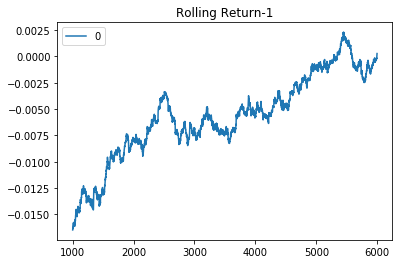

In [33]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

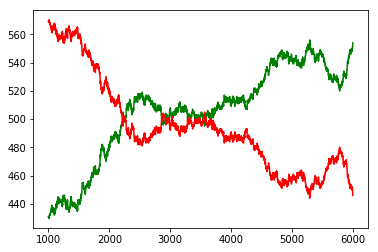

In [34]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

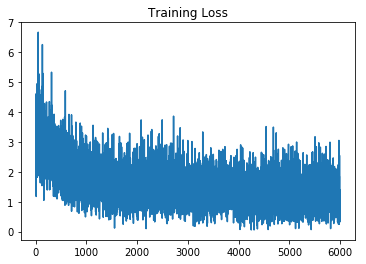

In [35]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

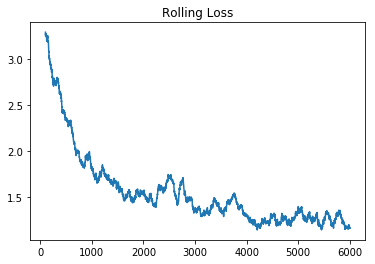

In [36]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

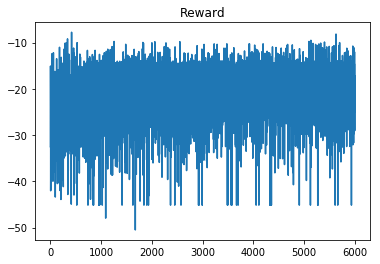

In [37]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

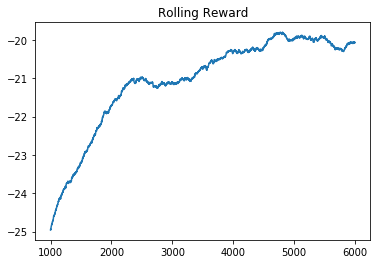

In [38]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

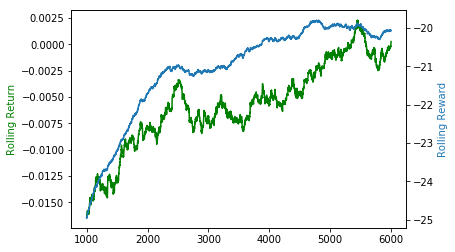

In [39]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

### Testing

Function to run episode with random actions:

In [40]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

Function to run episode with trained model and random model:

In [76]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        
        start_date = pd.to_datetime(plt_df.index[0]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(plt_df.index[-1]).strftime('%Y-%m-%d')
        
        #Plot some days before the start of the episode to see recent trends             
        start_index = np.where((raw_data.Open==plt_df.iloc[0].Open)&(raw_data.Close==plt_df.iloc[0].Close)&(raw_data.Volume==plt_df.iloc[0].Volume))[0][0]
        end_index = np.where((raw_data.Open==plt_df.iloc[-1].Open)&(raw_data.Close==plt_df.iloc[-1].Close)&(raw_data.Volume==plt_df.iloc[-1].Volume))[0][0]
        
        plt.plot(raw_data.iloc[max(start_index-10,0):start_index+1].index,raw_data.iloc[max(start_index-10,0):start_index+1].Open,'--',color='gray')
        plt.plot(raw_data.iloc[start_index:end_index+1].index,raw_data.iloc[start_index:end_index+1].Open,color='black')
        
        plt.ylim(min(raw_data.iloc[max(start_index-10,0):end_index].Open)*0.95, max(raw_data.iloc[max(start_index-10,0):end_index].Open)*1.05)
        plt.ylabel('Open Price')
        
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Sells
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.02*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.02*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Set up environment for testing:

In [77]:
import gym
import gym_market
import numpy as np
import imp

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_test, 
                  'raw_data':raw_data_test}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Run tests:

Return: 1.009
Random return: 0.957


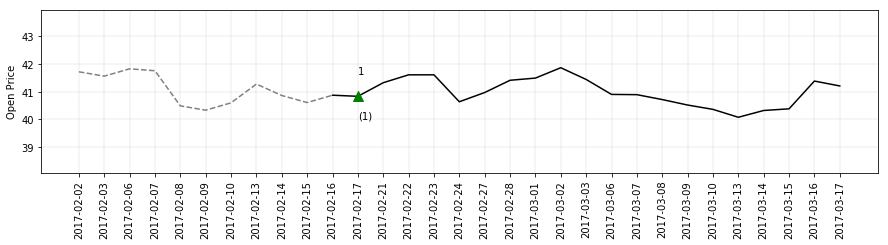

Return: 0.956
Random return: 0.890


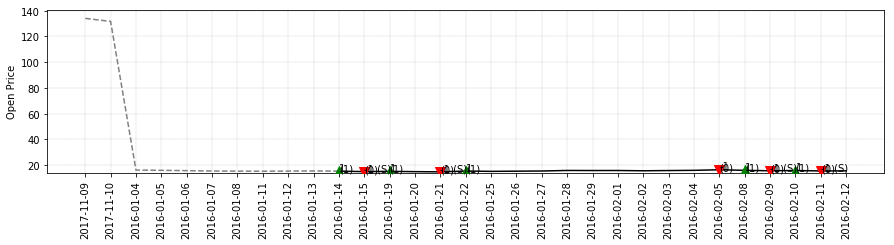

Return: 1.028
Random return: 0.940


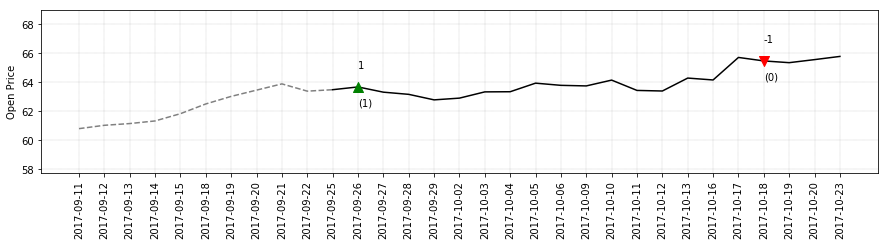

Return: 0.959
Random return: 1.086


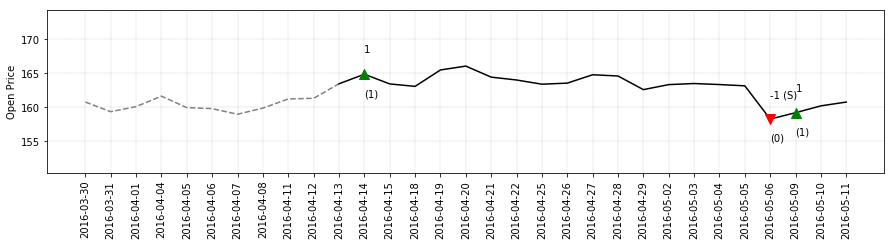

Return: 0.968
Random return: 1.043


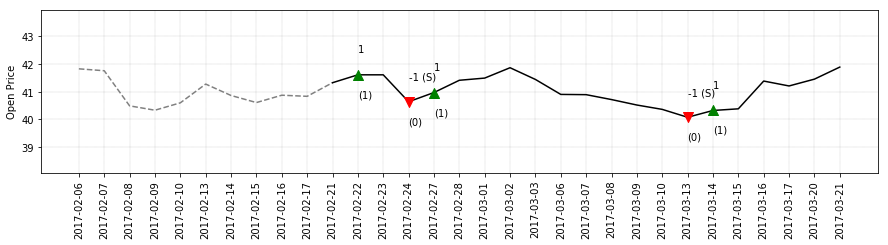

Return: 1.018
Random return: 1.055


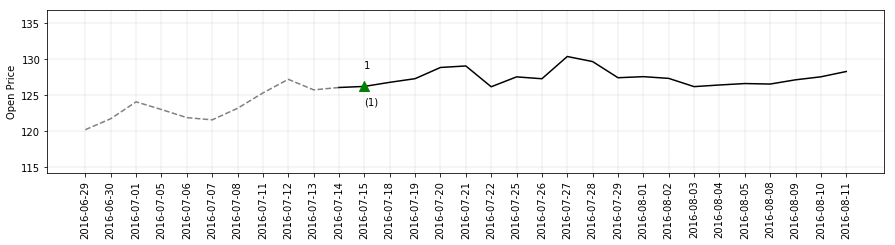

Return: 1.154
Random return: 1.032


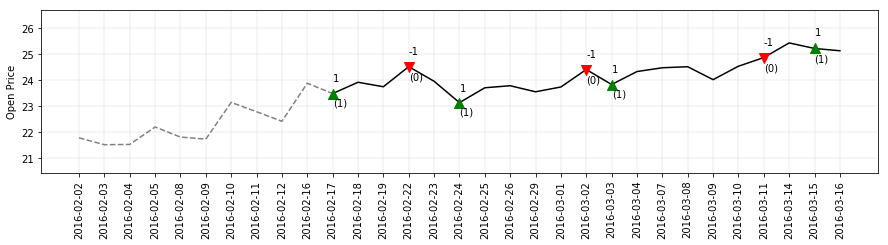

Return: 0.982
Random return: 0.991


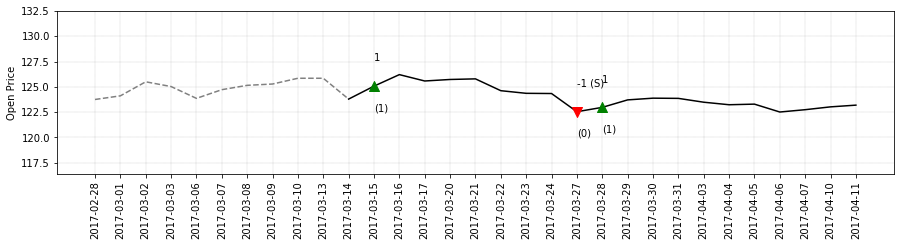

Return: 0.916
Random return: 1.014


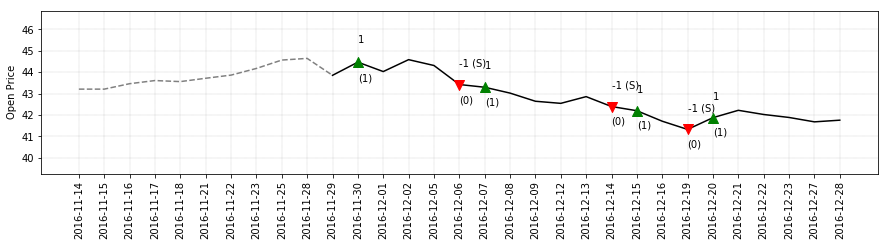

Return: 0.953
Random return: 0.946


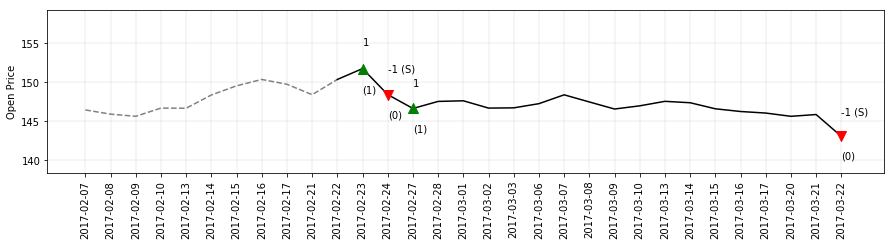

Return: 1.028
Random return: 0.991


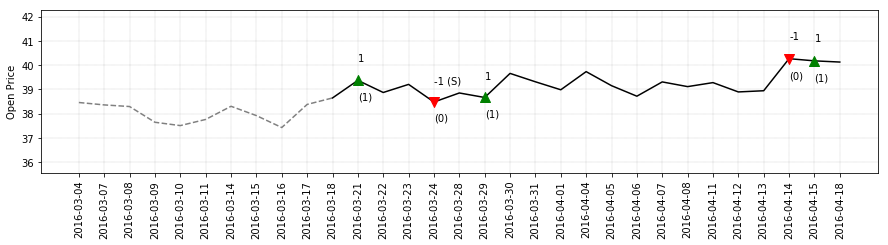

Return: 0.989
Random return: 0.955


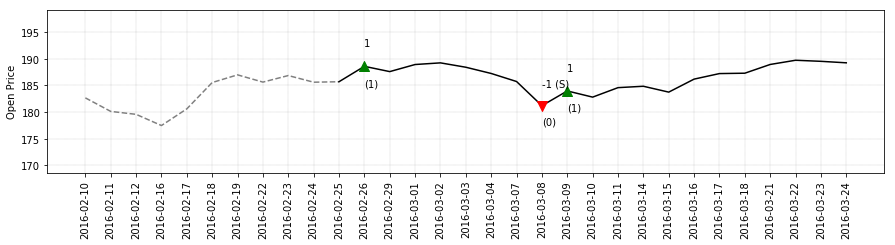

Return: 1.019
Random return: 0.968


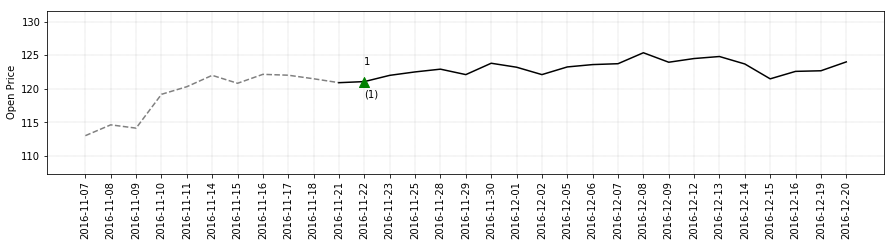

Return: 1.024
Random return: 1.040


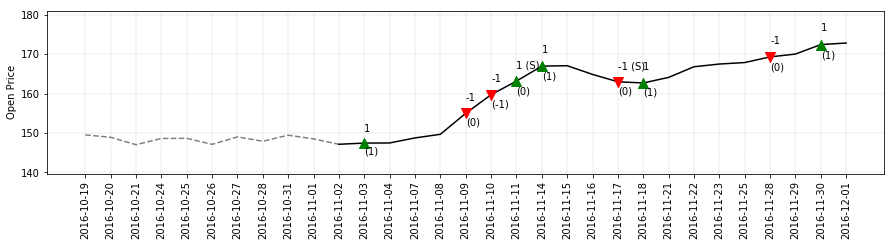

Return: 1.013
Random return: 0.994


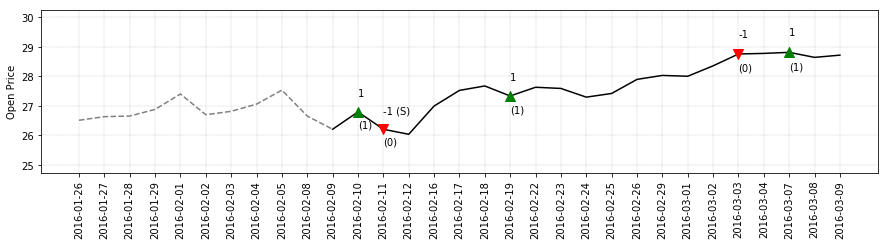

Return: 1.011
Random return: 0.847


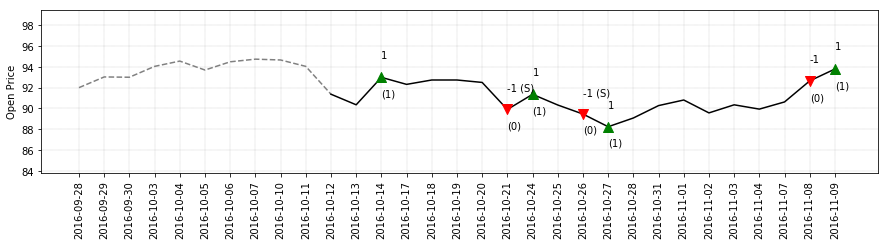

Return: 0.997
Random return: 0.991


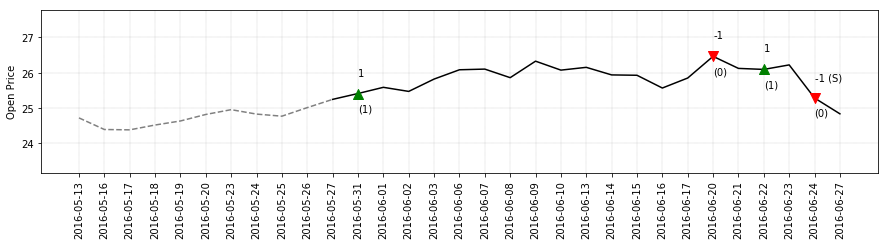

Return: 1.076
Random return: 0.914


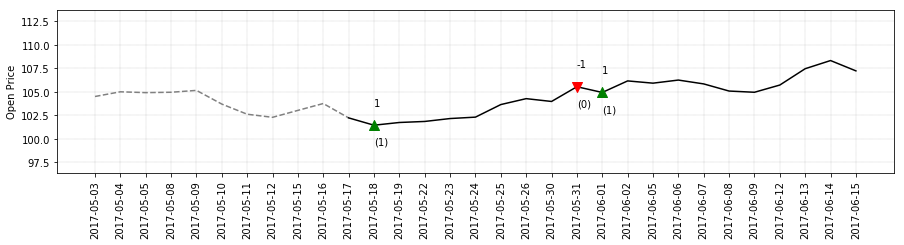

Return: 1.024
Random return: 0.937


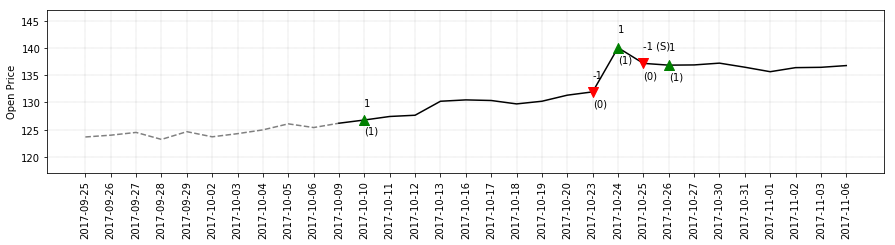

Return: 1.039
Random return: 0.937


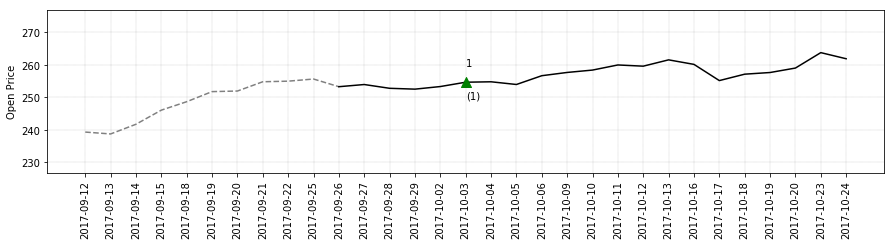

Return: 1.006
Random return: 0.910


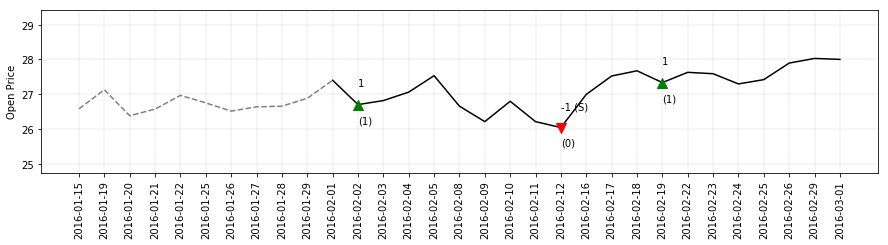

Return: 0.947
Random return: 1.019


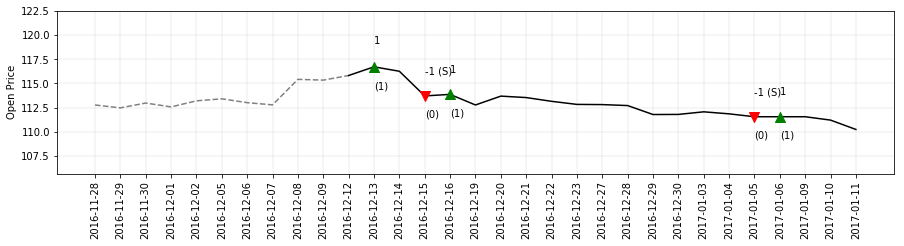

Return: 1.014
Random return: 0.915


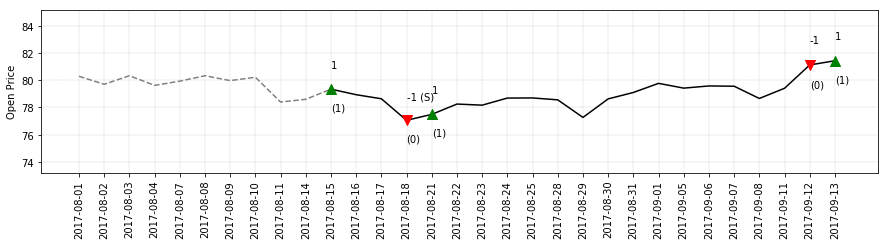

Return: 0.990
Random return: 0.892


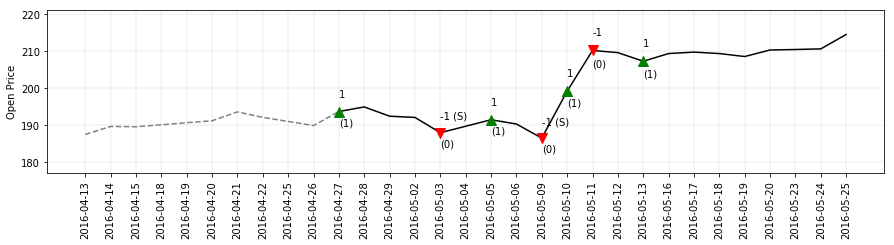

Return: 1.101
Random return: 0.991


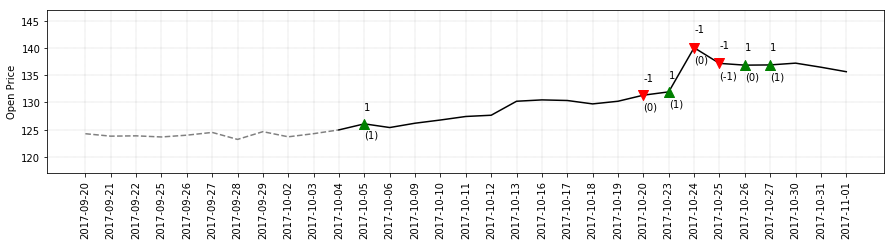

Return: 0.965
Random return: 0.948


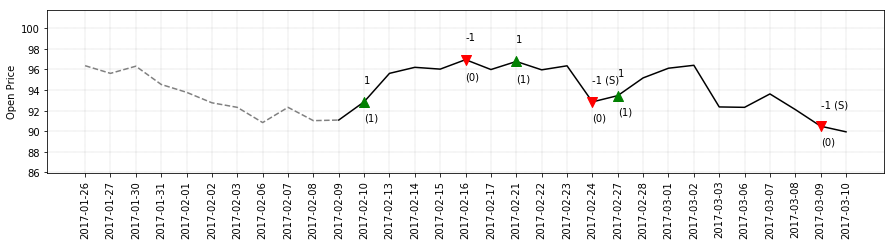

Return: 1.042
Random return: 0.975


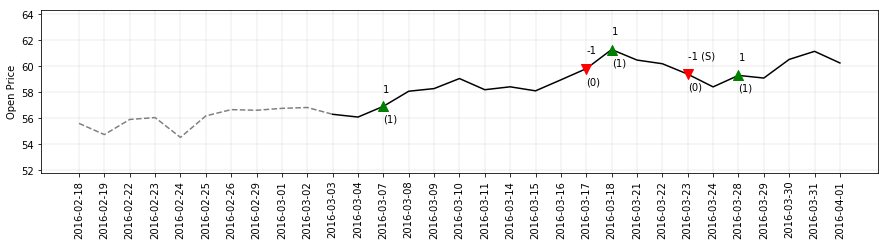

Return: 1.024
Random return: 1.006


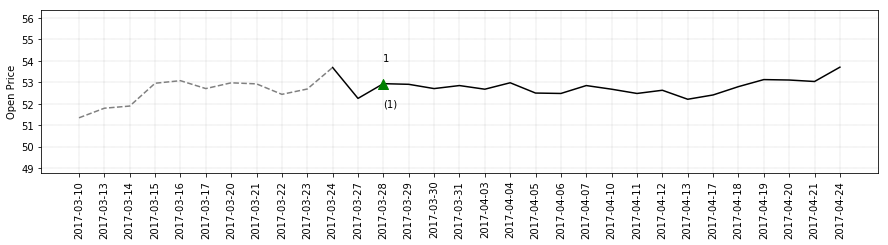

Return: 1.028
Random return: 1.006


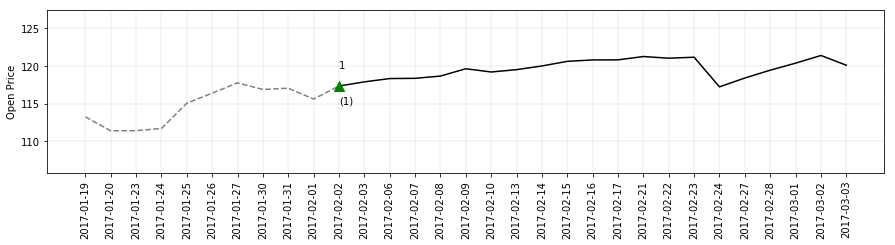

Return: 1.034
Random return: 0.914


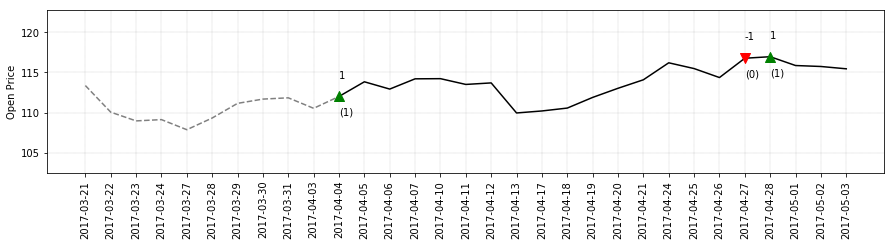

Return: 1.052
Random return: 1.114


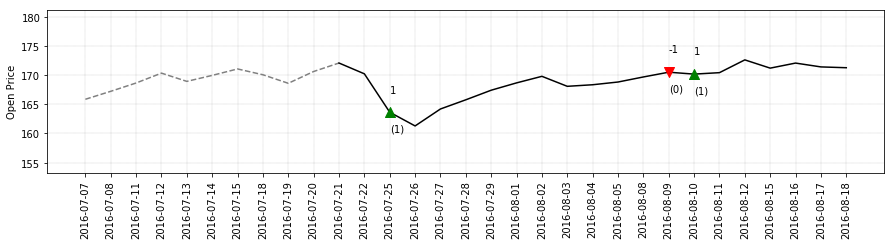

Return: 1.013
Random return: 1.010


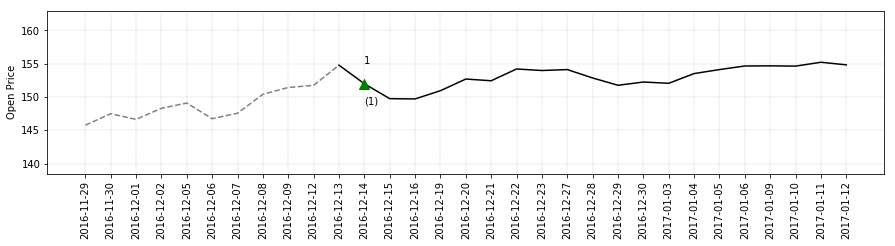

Return: 0.975
Random return: 0.986


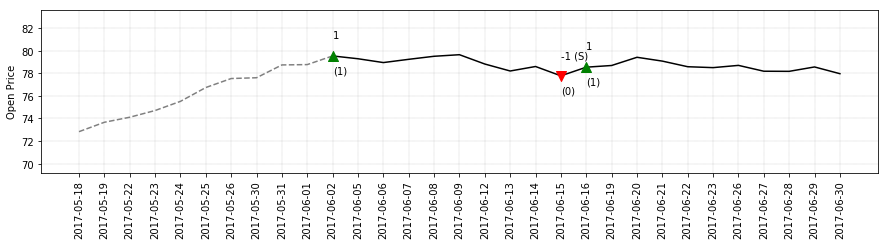

Return: 0.986
Random return: 0.980


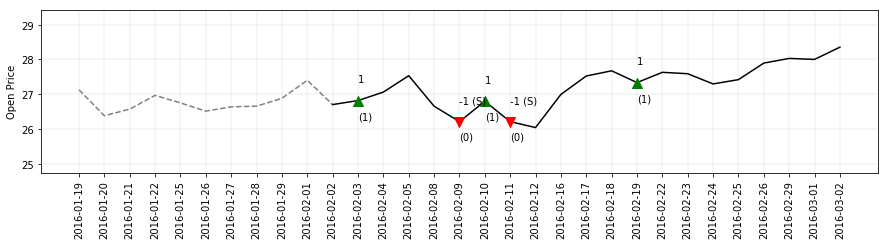

Return: 1.076
Random return: 0.988


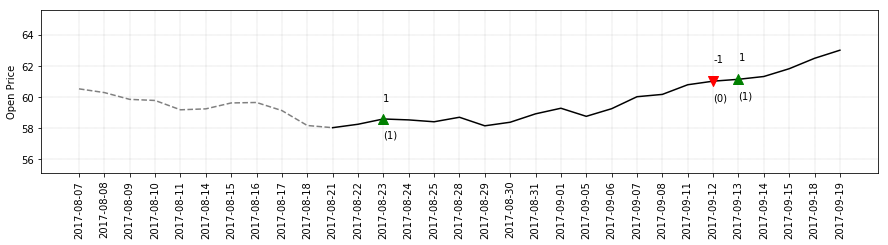

Return: 1.025
Random return: 0.954


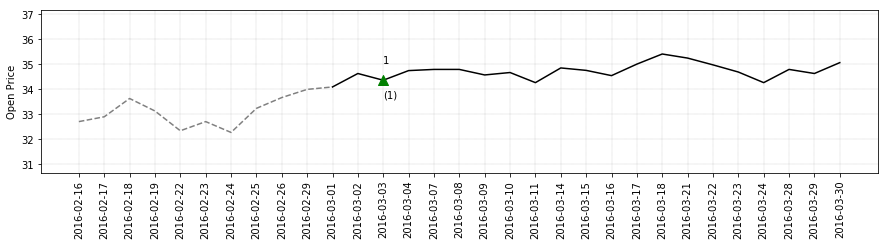

Return: 1.027
Random return: 0.954


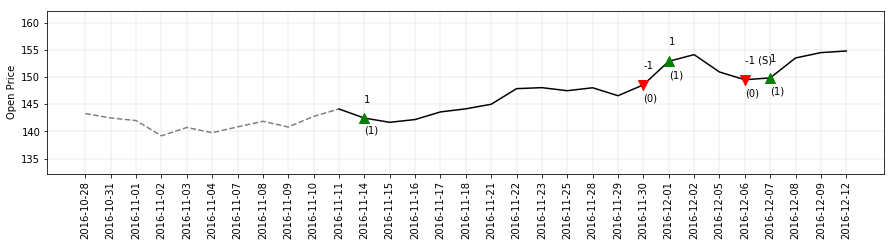

Return: 0.994
Random return: 1.018


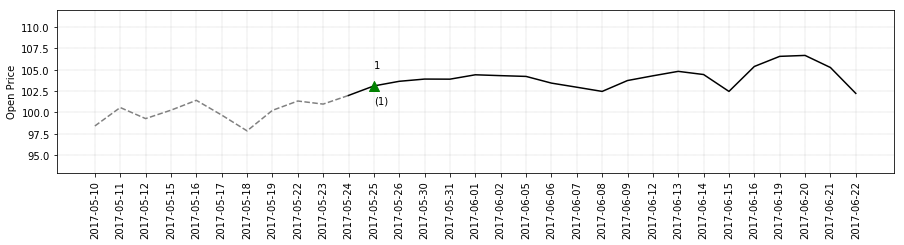

Return: 1.010
Random return: 0.923


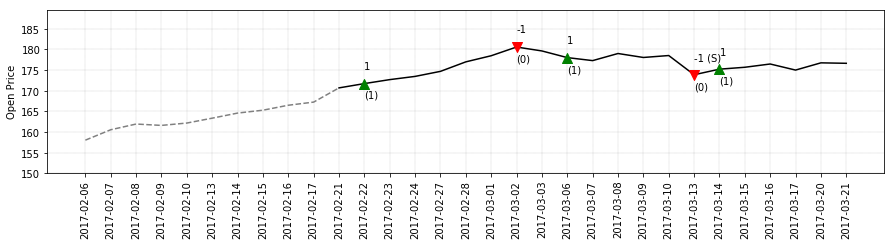

Return: 0.994
Random return: 1.014


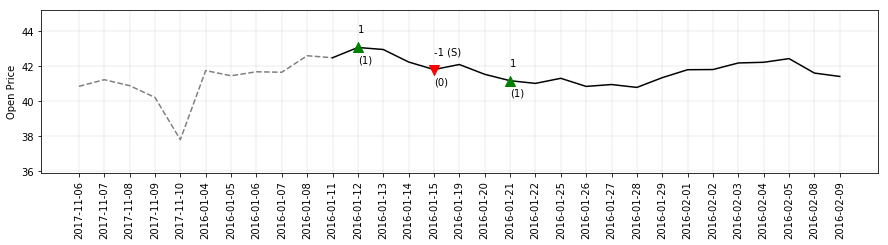

Return: 0.937
Random return: 0.932


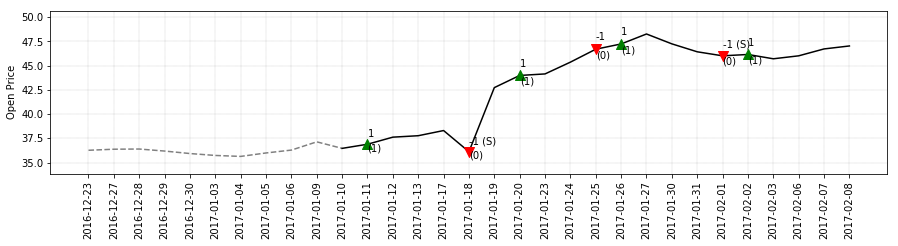

Return: 0.980
Random return: 0.874


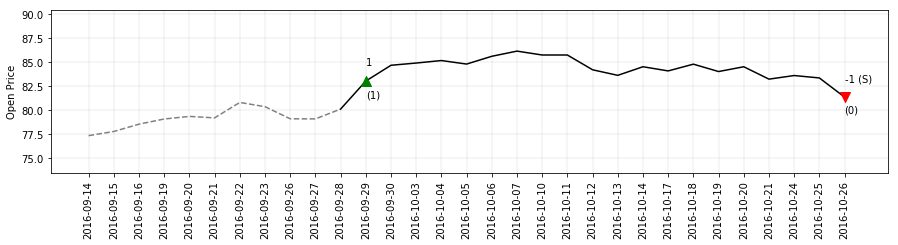

Return: 1.007
Random return: 0.995


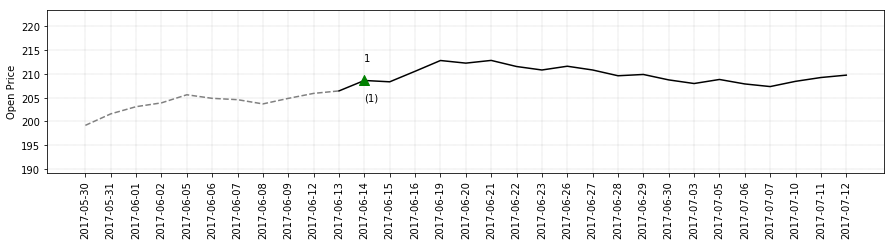

Return: 1.051
Random return: 0.944


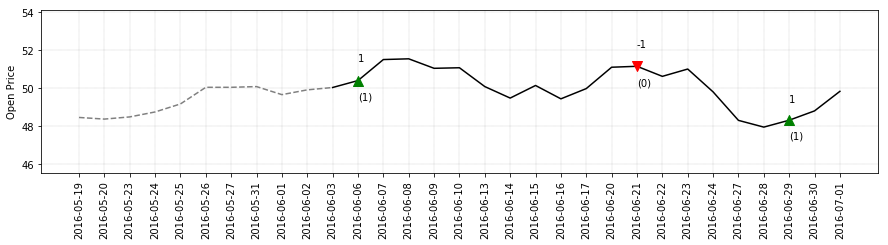

Return: 1.033
Random return: 0.973


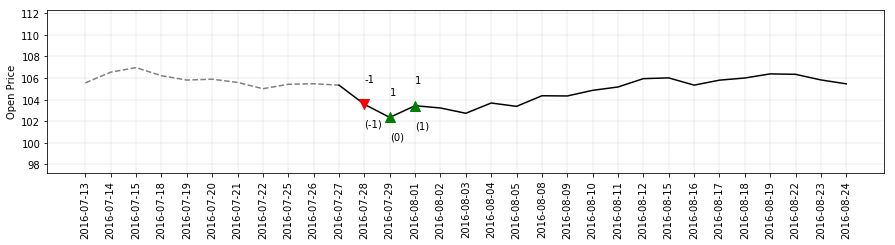

Return: 0.982
Random return: 1.024


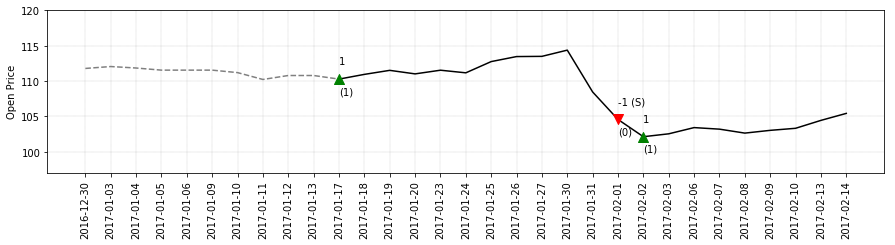

Return: 1.042
Random return: 1.154


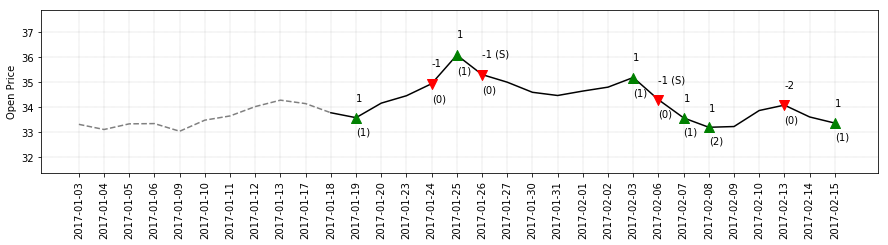

Return: 0.995
Random return: 0.961


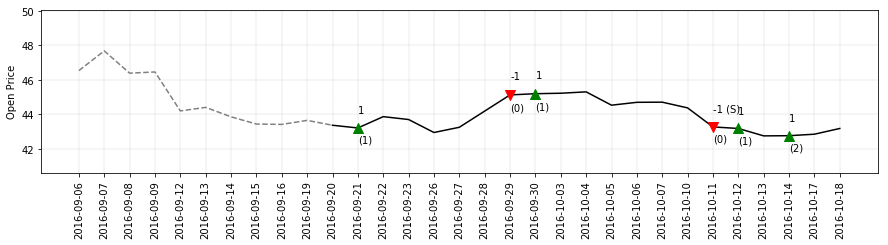

Return: 1.071
Random return: 1.042


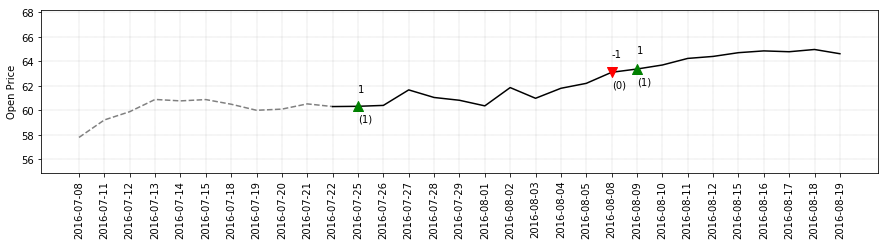

Return: 1.040
Random return: 0.941


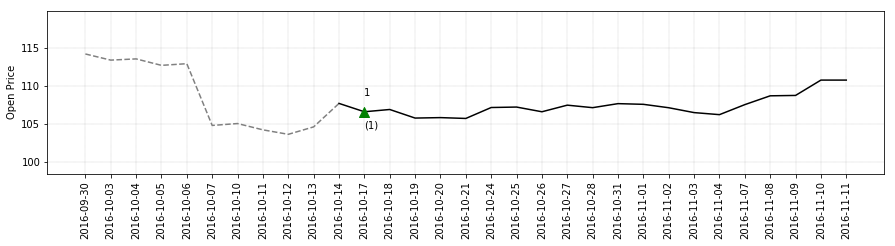

In [84]:
episode_count = 50

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data_test,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [85]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (50 episodes): 1.012
Average random return (50 episodes): 0.978
